<a href="https://colab.research.google.com/github/olavmoeller/OSU-Pitching-Graphics/blob/main/Practice%20Comparison/pitcher_practice_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

I want to make a quick and simple visualization that can show results of a training/bullpen session and compare it to previous sessions/data, in a similar format to the rest of my graphics.

# Notebook Setup

## Installing packages

In [ ]:
%cd /content/drive/MyDrive/colab/

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import api_scraper
from api_scraper import MLB_Scrape
import time
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import re
import requests

!pip install pyfonts google-colab-selenium
from pyfonts import load_font
import google_colab_selenium as gs

/content/drive/MyDrive/colab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 34.7 MB/s eta 0:00:00


## Plot setup

In [ ]:
stratum = load_font(font_url="https://github.com/ccheney/chromotion/blob/master/assets/fonts/stratum2-medium-webfont.ttf?raw=true")

plt.rcParams['figure.dpi'] = 300

### PITCH COLORS ###
pitch_colors = {
    ## Fastballs ##
    'FF': {'color': '#FF007D', 'name': '4-Seam Fastball'},
    'FA': {'color': '#FF007D', 'name': 'Fastball'},
    'SI': {'color': '#98165D', 'name': 'Sinker'},
    'FC': {'color': '#BE5FA0', 'name': 'Cutter'},

    ## Offspeed ##
    'CH': {'color': '#F79E70', 'name': 'Changeup'},
    'FS': {'color': '#FE6100', 'name': 'Splitter'},
    'SC': {'color': '#F08223', 'name': 'Screwball'},
    'FO': {'color': '#FFB000', 'name': 'Forkball'},

    ## Sliders ##
    'SL': {'color': '#67E18D', 'name': 'Slider'},
    'ST': {'color': '#1BB999', 'name': 'Sweeper'},
    'SV': {'color': '#376748', 'name': 'Slurve'},

    ## Curveballs ##
    'KC': {'color': '#311D8B', 'name': 'Knuckle Curve'},
    'CU': {'color': '#3025CE', 'name': 'Curveball'},
    'CS': {'color': '#274BFC', 'name': 'Slow Curve'},
    'EP': {'color': '#648FFF', 'name': 'Eephus'},

    ## Others ##
    'KN': {'color': '#867A08', 'name': 'Knuckleball'},
    'PO': {'color': '#472C30', 'name': 'Pitch Out'},
    'UN': {'color': '#9C8975', 'name': 'Unknown'},
}

# Create a dictionary mapping pitch types to their colors
dict_color = dict(zip(pitch_colors.keys(), [pitch_colors[key]['color'] for key in pitch_colors]))

# Create a dictionary mapping pitch types to their names
dict_pitch = dict(zip(pitch_colors.keys(), [pitch_colors[key]['name'] for key in pitch_colors]))


# Creating the graphic

I will build off of the original summary graphic to make 2 graphics, one about release data and one about pitch movement, as there is too much info for just one graphic. Additionally, these can be used separately depending on the goal of the session, which could include changing of mechanics or working on new pitch shapes.

## Data Processing

While I don't have experience with trackman data yet, I will be able to update this code once I have seen the way it works. For now, as an example, I will split Eric Segura's outing into 2 equal parts, acting as if the first half was one bullpen, and the second half was the next. I will use the metrics shown by trackman on their website as the ones of interest, and calculate them if it isn't done by statcast.

In [ ]:
# Activating the scraper
scraper = MLB_Scrape()

osu_games = {
    2024: [763702,763704,763697,763701],
    2025: [796298,796296,796293,796291,795107,795103,795104,791896,791894,791892]}

# Creating a function that can return the full dataframe for any set of games
def get_stat_data(gamelist):
    # Activating the scraper
    scraper = MLB_Scrape()

    # Getting the game data for the requested games, making it a pandas dataframe
    game_data = scraper.get_data(game_list_input=gamelist)
    data_df = scraper.get_data_df(data_list=game_data)
    df = data_df.to_pandas()

    # Adding columns for relevant pitching results
    df['in_zone'] = (df['zone'] < 10)
    df['out_zone'] = (df['zone'] > 10)
    df['chase'] = (df.in_zone==False) & (df.is_swing)

    # Adding a year column
    df['year'] = pd.to_datetime(df['game_date']).dt.year

    return df

# Creating a function that gets only pitches thrown by a selected pitcher over a selected year
def player_year_data(playername, year):
    year_df = get_stat_data(osu_games[year])
    return year_df[year_df['pitcher_name'] == playername]

# Creating a function that will turn statcast data into trackman data
def statcast_to_trackman(pitchername, gamelist):

    # Calling the relevant game(s) and making a dataframe
    game_data = scraper.get_data(game_list_input = gamelist)
    data_df = scraper.get_data_df(data_list=game_data)
    pd_df = data_df.to_pandas()

    # Filtering by pitcher of interest
    pitcher_df_raw = pd_df[pd_df['pitcher_name'] == pitchername].reset_index(drop=True)

    # Listing the columns we need to keep for trackman calculations
    columns_to_keep = ['pitcher_name', 'game_date', 'pitcher_hand', 'pitch_type', 'start_speed', 'spin_rate', 'spin_direction', 'z0', 'x0', 'y0', 'extension', 'vx0', 'vy0', 'vz0', 'ivb', 'hb', 'pz', 'px', 'ax', 'ay', 'az']

    # Minimizing our dataset to just what I need to simulate trackman
    trackman_raw = pitcher_df_raw[columns_to_keep]

    # Creating a function that calculates metrics recorded by trackman
    def more_metrics(df: pd.DataFrame):
        new_df = df.copy()

        # Renaming some metrics
        new_df['release_speed'] = new_df['start_speed']
        new_df['spin_axis'] = new_df['spin_direction']

        # Finding velocity at release point
        new_df['vy_s'] = -np.sqrt(new_df['vy0']**2 + 2 * new_df['ay'] * (60.5 - new_df['extension'] - new_df['y0']))
        new_df['t_s'] = (new_df['vy0'] - new_df['vy_s']) / new_df['ay']
        new_df['vz_s'] = new_df['vz0'] - new_df['az'] * new_df['t_s']
        new_df['vx_s'] = new_df['vx0'] - new_df['ax'] * new_df['t_s']

        # Finding actual release point
        new_df['release_height'] = new_df['z0'] - new_df['vz_s'] * new_df['t_s'] - 0.5 * new_df['az'] * (new_df['t_s']**2)
        new_df['release_side'] = new_df['x0'] - new_df['vx_s'] * new_df['t_s'] - 0.5 * new_df['ax'] * (new_df['t_s']**2)

        # Calculating release angles
        new_df['VRA'] = -np.arctan(new_df['vz_s'] / new_df['vy_s']) * (180 / np.pi)
        new_df['HRA'] = -np.arctan(new_df['vx_s'] / new_df['vy_s']) * (180 / np.pi)

        # Finding velocities at the plate
        new_df['vyf'] = -np.sqrt((new_df['vy0'])**2 - (2 * new_df['ay'] * (50 - 17/12)))
        new_df['t'] = (new_df['vyf'] - new_df['vy0']) / new_df['ay']
        new_df['vzf'] = new_df['vz0'] + new_df['az'] * new_df['t']
        new_df['vxf'] = new_df['vx0'] + new_df['ax'] * new_df['t']

        # Calculating plate approach angles
        new_df['VAA'] = -np.arctan(new_df['vzf'] / new_df['vyf']) * (180 / np.pi)
        new_df['HAA'] = -np.arctan(new_df['vxf'] / new_df['vyf']) * (180 / np.pi)

        return new_df

    # Adding more metrics function
    tm_raw_full = more_metrics(trackman_raw).dropna()

    return tm_raw_full

tm_data = statcast_to_trackman('Eric Segura', [763701]) # While I could use all 2024 games, I know the ID, so that's simpler

# Splitting it in half
df_1 = tm_data.iloc[:len(tm_data)//2]
df_2 = tm_data.iloc[len(tm_data)//2:]

tm_data

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 1/1 [00:00<00:00,  1.67iteration/s]


Converting Data to Dataframe.


pitcher_name   game_date pitcher_hand pitch_type  start_speed  spin_rate  \
0   Eric Segura  2024-02-25            R         SI         92.9     2259.0   
1   Eric Segura  2024-02-25            R         SI         91.9     2376.0   
2   Eric Segura  2024-02-25            R         CU         79.7     2308.0   
3   Eric Segura  2024-02-25            R         SI         93.4     2439.0   
4   Eric Segura  2024-02-25            R         SI         93.1     2396.0   
..          ...         ...          ...        ...          ...        ...   
77  Eric Segura  2024-02-25            R         SI         91.1     2354.0   
78  Eric Segura  2024-02-25            R         CH         84.4     1848.0   
79  Eric Segura  2024-02-25            R         CU         78.4     2112.0   
80  Eric Segura  2024-02-25            R         CU         77.6     2076.0   
81  Eric Segura  2024-02-25            R         SI         90.3     2275.0   

    spin_direction        z0        x0         y0  ...  release_height  \
0            249.0  4.630344 -2.288366  50.004772  ...        4.775492   
1            242.0  4.684441 -2.202959  50.005283  ...        4.756362   
2             58.0  4.931990 -2.140267  50.000576  ...        4.846557   
3            246.0  4.702093 -2.219723  50.005599  ...        4.819659   
4            242.0  4.772016 -1.990875  50.004043  ...        4.800380   
..             ...       ...       ...        ...  ...             ...   
77           242.0  4.972505 -2.075351  50.004450  ...        4.940120   
78           255.0  4.688295 -2.215494  50.000932  ...        4.686211   
79            57.0  4.920853 -2.312316  50.000109  ...        4.862422   
80            64.0  4.924752 -2.242595  50.002971  ...        4.792153   
81           238.0  5.016863 -1.996863  50.004811  ...        4.950307   

    release_side       VRA       HRA         vyf         t        vzf  \
0      -2.583312 -1.945210  4.335934 -123.060725  0.376694 -13.325508   
1      -2.463191 -0.804583  3.535633 -121.695997  0.380716 -10.498530   
2      -2.344306  1.505352  2.779196 -104.453874  0.441160 -13.934254   
3      -2.481090 -1.524934  3.779624 -123.886558  0.374269 -11.954376   
4      -2.386959 -0.255339  5.523446 -123.517019  0.375965  -8.941646   
..           ...       ...       ...         ...       ...        ...   
77     -2.319558  0.655042  3.924317 -121.215065  0.383186  -8.681649   
78     -2.438012  0.273216  3.329099 -112.824247  0.412417 -14.008301   
79     -2.416444  1.137019  1.380292 -104.470134  0.444527 -14.444666   
80     -2.279671  2.151341  0.414949 -103.113988  0.449769 -12.046353   
81     -2.238767  1.112116  3.569700 -121.057184  0.385052  -7.572632   

          vxf       VAA       HAA  
0    2.506971 -6.180136  1.167058  
1    1.720992 -4.930613  0.810207  
2   10.231708 -7.598454  5.594522  
3    2.018939 -5.511665  0.933648  
4    5.835876 -4.140534  2.705073  
..        ...       ...       ...  
77   2.492188 -4.096635  1.177838  
78   1.395069 -7.077645  0.708425  
79   8.454101 -7.872146  4.626500  
80   6.221610 -6.663408  3.452881  
81   0.965028 -3.579426  0.456733  

[81 rows x 37 columns]

## Charts

While I have the code for some charts already in a different workbook, those need to exist here too, in addition to the new charts I'll create.

### Old Charts

Adding the code for charts I have previously made.

#### Short Form Plot

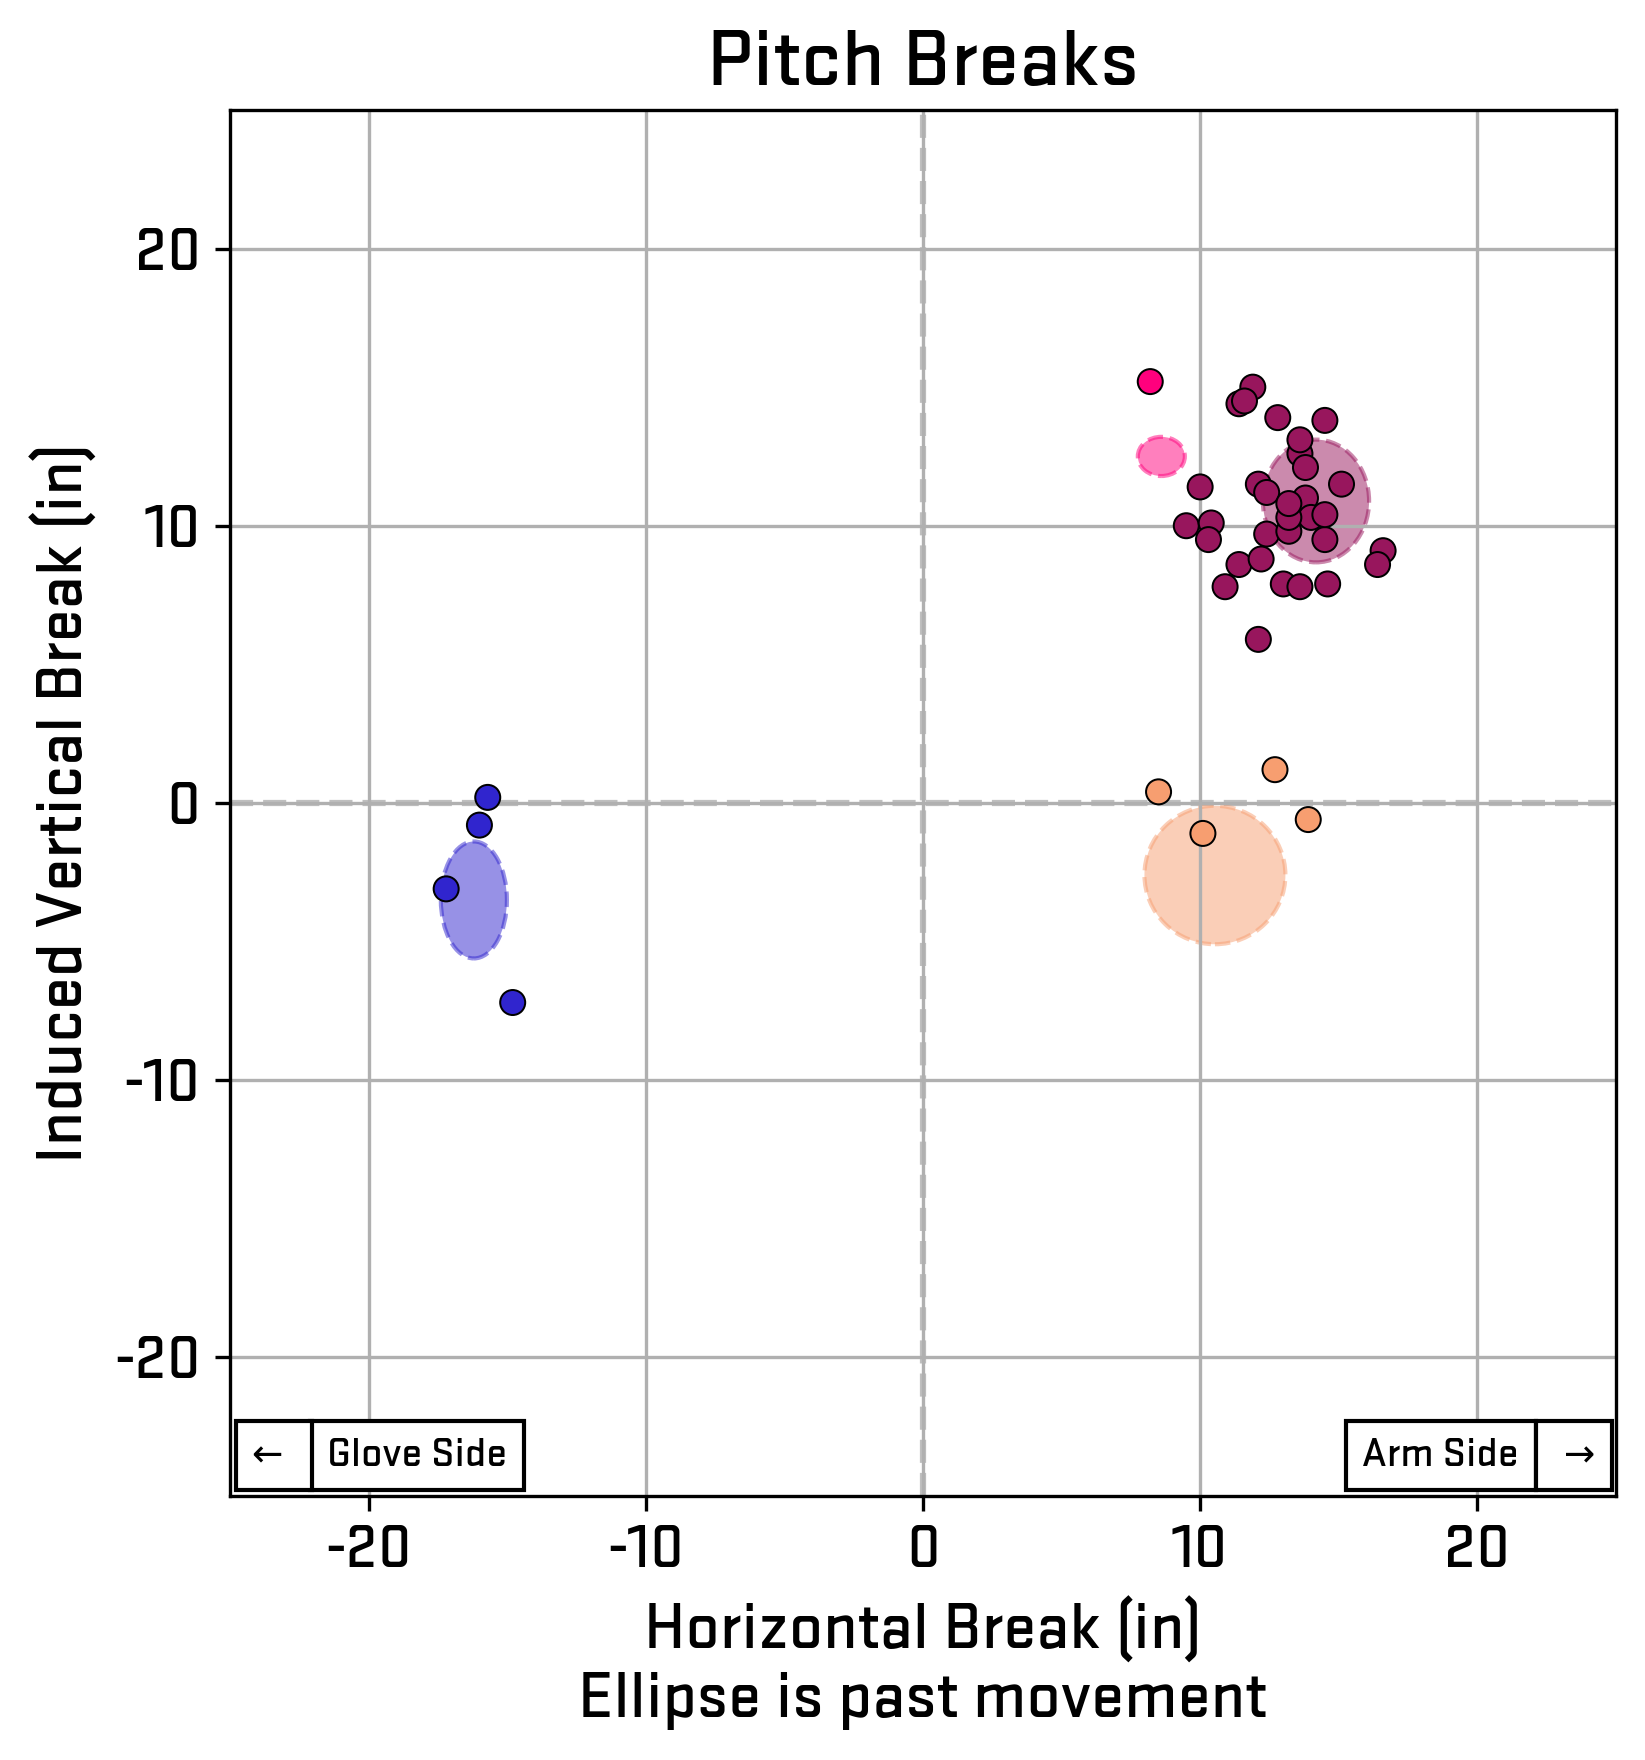

In [ ]:
def break_plot(df, past_df, ax):

    # Finding the mean and sd of the past session's movements
    ellipse_data = past_df.groupby('pitch_type').agg(
        ivb_mean = ('ivb','mean'),  # Average vertical movement
        ivb_sd = ('ivb','std'),  # Standard deviation of vertical movement
        hb_mean = ('hb','mean'),  # Average horizontal movement
        hb_sd = ('hb','std'),  # Standard deviation of horizontal movement
        ).fillna(0).reset_index()

    # Check if the pitcher throws with the right hand
    if df['pitcher_hand'].values[0] == 'R':
        sns.scatterplot(ax=ax,
                        x=df['hb'],
                        y=df['ivb'],
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=2)

        # Plot the past ellipses of past movement
        for i in ellipse_data['pitch_type']:
            loc = ellipse_data[ellipse_data['pitch_type'] == i]
            col = dict_color[i]
            ax.add_patch(Ellipse((loc['hb_mean'].iloc[0], loc['ivb_mean'].iloc[0]), 2 * loc['hb_sd'].iloc[0], 2 * loc['ivb_sd'].iloc[0], edgecolor=col, facecolor=col, linestyle='--', alpha=0.5))


    # Check if the pitcher throws with the left hand
    if df['pitcher_hand'].values[0] == 'L':
        sns.scatterplot(ax=ax,
                        x=df['hb']*-1,
                        y=df['ivb'],
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=2)

        # Plot the past ellipses of past movement
        for i in ellipse_data['pitch_type']:
            loc = ellipse_data[ellipse_data['pitch_type'] == i]
            col = dict_color[i]
            ax.add_patch(Ellipse((-loc['hb_mean'].iloc[0], loc['ivb_mean'].iloc[0]), 2 * loc['hb_sd'].iloc[0], 2 * loc['ivb_sd'].iloc[0], edgecolor=col, facecolor=col, linestyle='--', alpha=0.5))


    # Draw horizontal and vertical lines at y=0 and x=0 respectively
    ax.axhline(y=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)
    ax.axvline(x=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)

    # Finding the mean and sd of the past session's movements
    ellipse_data = past_df.groupby('pitch_type').agg(
        ivb_mean = ('ivb','mean'),  # Average vertical movement
        ivb_sd = ('ivb','std'),  # Standard deviation of vertical movement
        hb_mean = ('hb','mean'),  # Average horizontal movement
        hb_sd = ('hb','std'),  # Standard deviation of horizontal movement
        ).fillna(0).reset_index()

    # Set the labels for the x and y axes
    ax.set_xlabel('Horizontal Break (in)\nEllipse is past movement', font=stratum, fontsize=16)
    ax.set_ylabel('Induced Vertical Break (in)', font=stratum, fontsize=16)

    # Set the title of the plot
    ax.set_title("Pitch Breaks", font=stratum, fontsize=20)

    # Remove the legend
    ax.get_legend().remove()

    # Set the tick positions and labels for the x and y axes
    ax.set_xticks(range(-20, 21, 10))
    ax.set_xticklabels(range(-20, 21, 10), font=stratum, fontsize=15)
    ax.set_yticks(range(-20, 21, 10))
    ax.set_yticklabels(range(-20, 21, 10), font=stratum, fontsize=15)
    ax.grid()

    # Set the limits for the x and y axes
    ax.set_xlim((-25, 25))
    ax.set_ylim((-25, 25))

    # Add text annotations based on the pitcher's throwing hand
    if df['pitcher_hand'].values[0] == 'R':
        ax.text(-21.5, -24.2, s='Glove Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-24.2, -24.2, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(21.5, -24.2, s='Arm Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(22.7, -24.2, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    if df['pitcher_hand'].values[0] == 'L':
        ax.invert_xaxis()
        ax.text(21.5, -24.2, s='Arm Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(24.2, -24.2, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(-21.5, -24.2, s='Glove Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-22.7, -24.2, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal', adjustable='box')

    # Format the x and y axis tick labels as integers
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

break_plot(df=df_2, past_df=df_1, ax=plt.subplots(figsize=(6, 6))[1])


#### Velocity Histogram

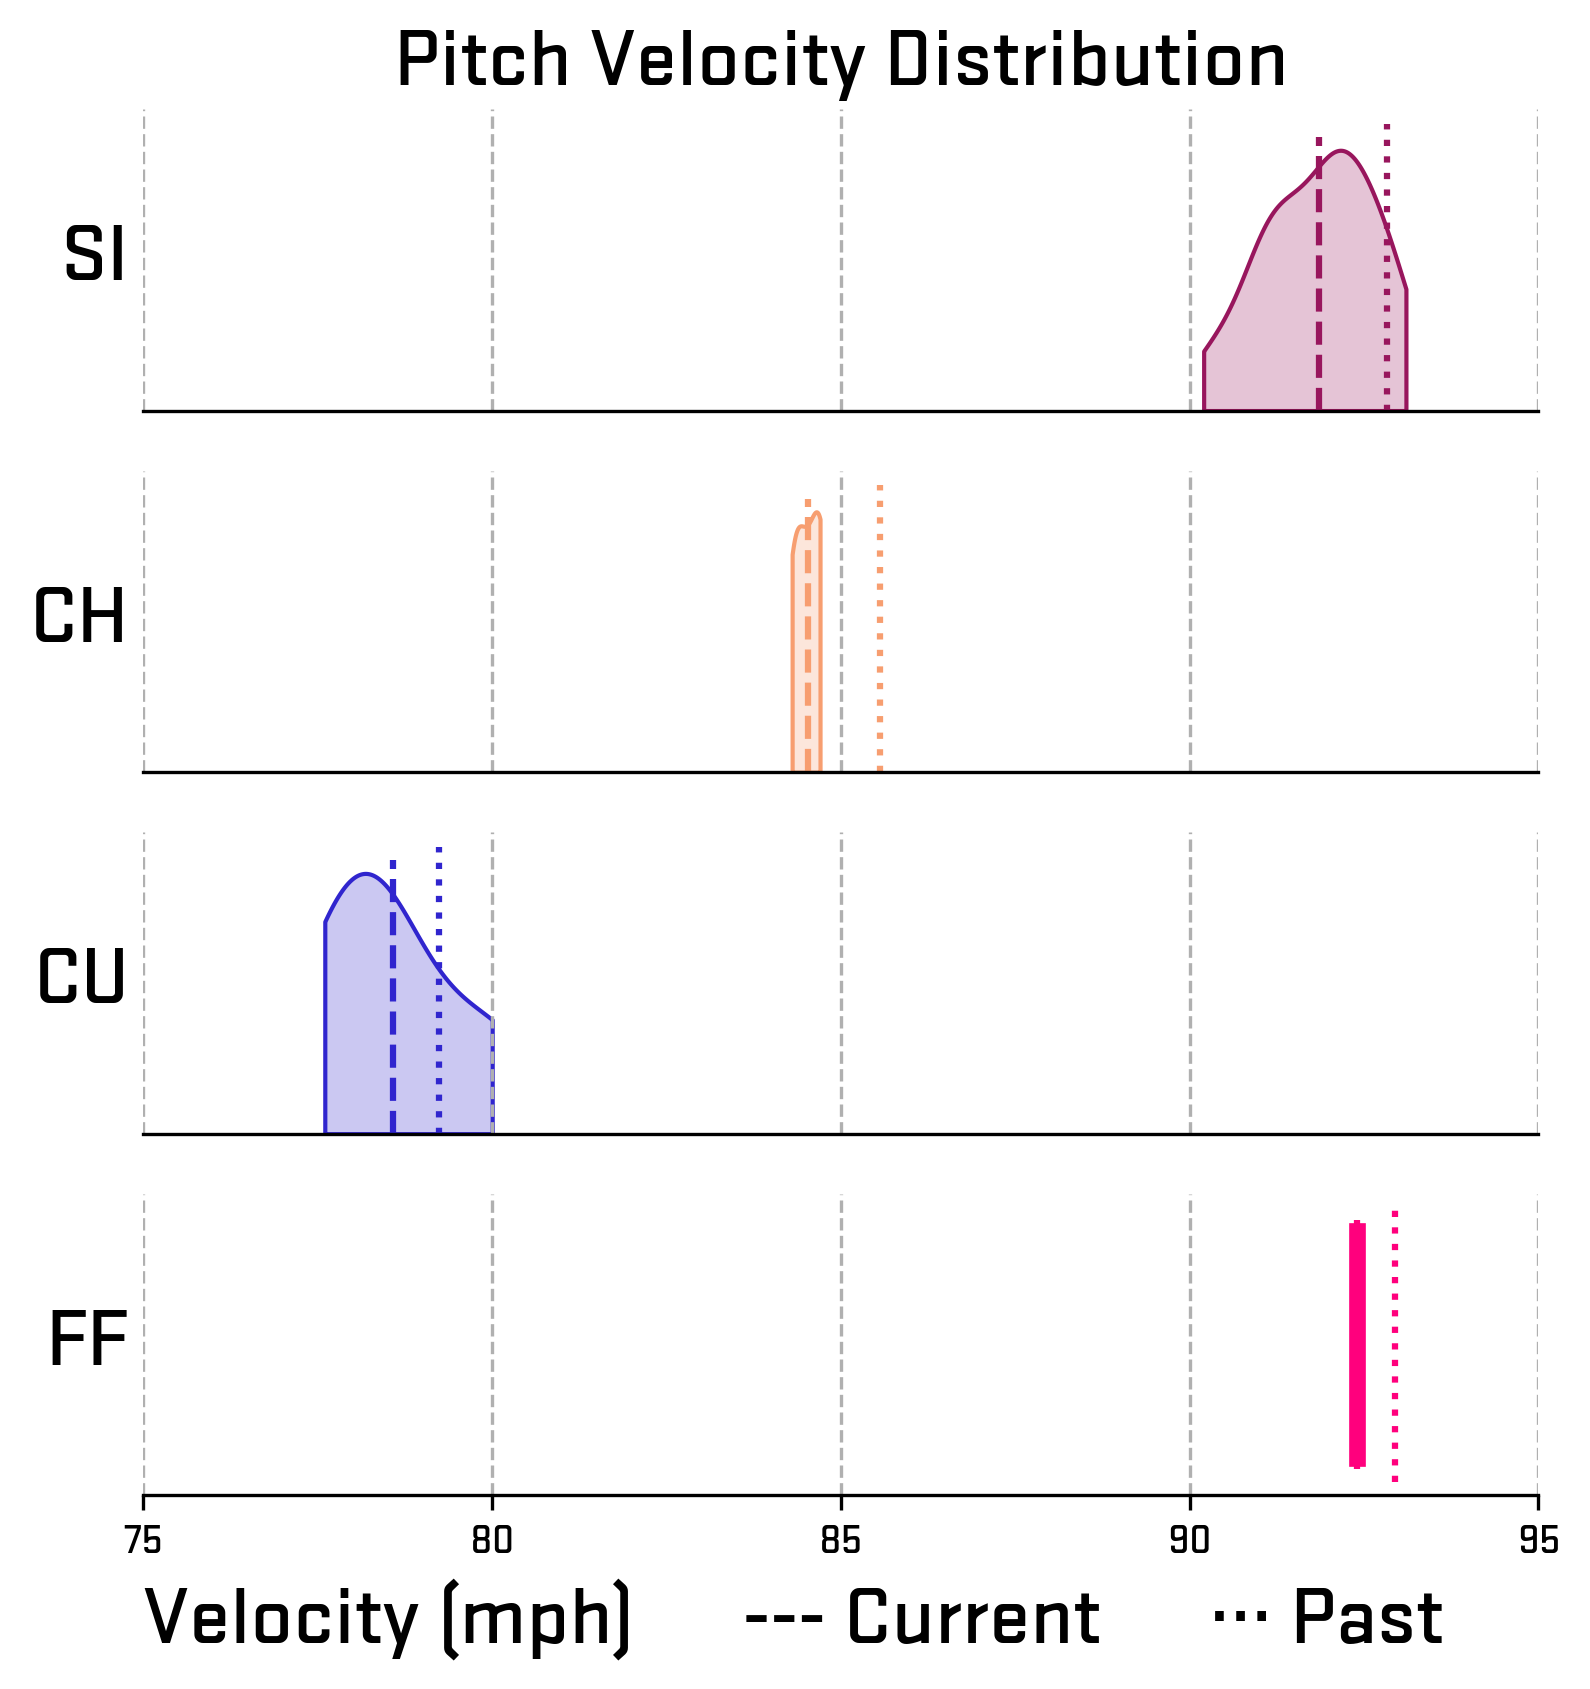

In [ ]:
def velocity_chart(df, past_df, fig, ax, gs, gs_x, gs_y):

    # Get the count of each pitch type and sort them in descending order
    sorted_value_counts = df['pitch_type'].value_counts().sort_values(ascending=False)

    # Get the list of pitch types ordered from most to least frequent
    items_in_order = sorted_value_counts.index.tolist()

    # Turn off the axis and set the title for the main plot
    ax.axis('off')
    ax.set_title('Pitch Velocity Distribution', font=stratum, fontsize=20)

    # Create a grid for the inner subplots
    inner_grid_1 = gridspec.GridSpecFromSubplotSpec(len(items_in_order), 1, subplot_spec=gs[gs_x[0]:gs_x[-1], gs_y[0]:gs_y[-1]])
    ax_top = []

    # Create subplots for each pitch type
    for inner in inner_grid_1:
        ax_top.append(fig.add_subplot(inner))
    ax_number = 0
    for i in items_in_order:
        # Check if all release speeds for the pitch type are the same
        if np.unique(df[df['pitch_type'] == i]['release_speed']).size == 1:
            # Plot a single line if all values are the same
            ax_top[ax_number].plot([np.unique(df[df['pitch_type'] == i]['release_speed']),
                              np.unique(df[df['pitch_type'] == i]['release_speed'])], [0, 1], linewidth=4,
                              color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]], zorder=20)
        else:
            # Plot the KDE for the release speeds
            sns.kdeplot(df[df['pitch_type'] == i]['release_speed'], ax=ax_top[ax_number], fill=True,
                  clip=(df[df['pitch_type'] == i]['release_speed'].min(), df[df['pitch_type'] == i]['release_speed'].max()),
                  color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]])

        # Plot the mean release speed for the current data
        df_average = df[df['pitch_type'] == i]['release_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                      [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                      color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                      linestyle='--')

        # Plot the mean release speed for the previous/comparison data
        df_average = past_df[past_df['pitch_type'] == i]['release_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                      [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                      color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                      linestyle=':')

        # Define min and max of velo rounded to nearest 5 for limits/ticks
        min_velo = np.floor(df['release_speed'].min() / 5).astype(int) * 5
        max_velo = np.ceil(df['release_speed'].max() / 5).astype(int) * 5

        # Set the x-axis limits
        ax_top[ax_number].set_xlim(min_velo, max_velo + 1)
        ax_top[ax_number].set_xlabel('')
        ax_top[ax_number].set_ylabel('')

        # Hide the top, right, and left spines for all but the last subplot
        if ax_number < len(items_in_order) - 1:
            ax_top[ax_number].spines['top'].set_visible(False)
            ax_top[ax_number].spines['right'].set_visible(False)
            ax_top[ax_number].spines['left'].set_visible(False)
            ax_top[ax_number].tick_params(axis='x', colors='none')

        # Set the x-ticks and y-ticks
        ax_top[ax_number].set_xticks(range(min_velo, max_velo + 1, 5))
        ax_top[ax_number].set_yticks([])
        ax_top[ax_number].grid(axis='x', linestyle='--')
        for label in ax_top[ax_number].get_xticklabels():
            label.set_fontproperties(stratum)

        # Add text label for the pitch type
        ax_top[ax_number].text(-0.01, 0.5, i, transform=ax_top[ax_number].transAxes,
                      fontsize=20, va='center', ha='right', font=stratum)
        ax_number += 1

    # Hide the top, right, and left spines for the last subplot
    ax_top[-1].spines['top'].set_visible(False)
    ax_top[-1].spines['right'].set_visible(False)
    ax_top[-1].spines['left'].set_visible(False)

    # Set the x-ticks and x-label for the last subplot
    ax_top[-1].set_xticks(list(range(min_velo, max_velo + 1, 5)))
    ax_top[-1].set_xlabel('Velocity (mph)      --- Current      ··· Past', fontsize=20, font=stratum, loc='left')


fig, ax = plt.subplots(figsize=(6, 6))
velocity_chart(df=df_2, past_df=df_1, fig=fig, ax=ax, gs=gridspec.GridSpec(1, 1), gs_x=[0, 1], gs_y=[0, 1])


### New Charts

I will include a couple of new charts for these graphics, as the pitch plinko isn't relevant for a bullpen session, and there are some new charts I want to showcase, being relevant to the two graphics I will create.

#### Location Plot

With a similar format to the movement plot, I want to create a chart that shows the locations of every pitch in the strike zone, as this is tracked by Trackman. This allows pitchers to work on location and see the results visually, and compare to a previous session to see improvements or changes.

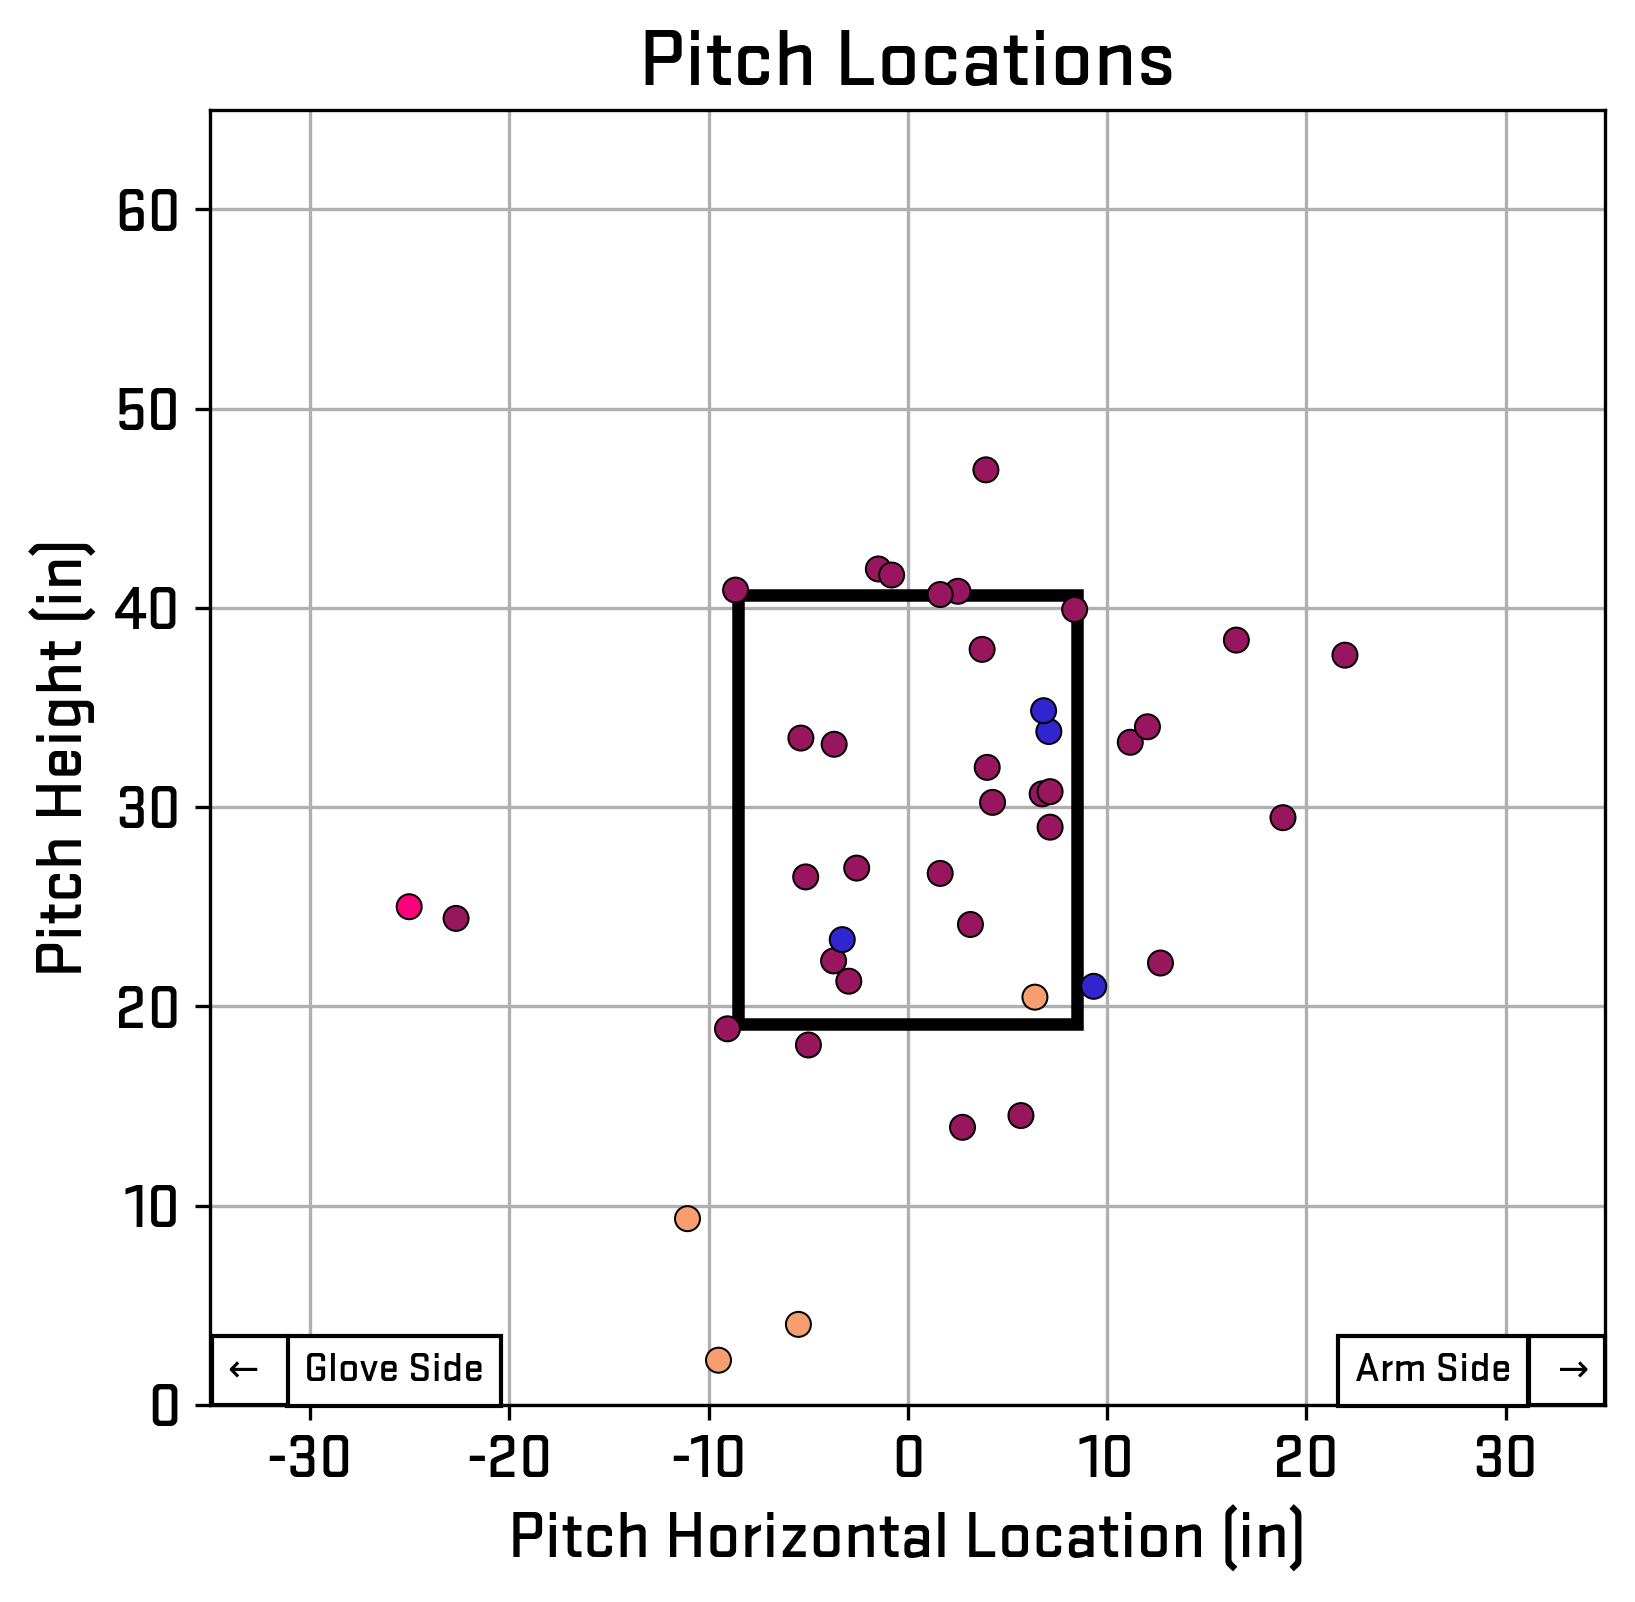

In [ ]:
def loc_plot(df, ax):
    # Check if the pitcher throws with the right hand
    if df['pitcher_hand'].values[0] == 'R':
        sns.scatterplot(ax=ax,
                        x=df['px']*-12,
                        y=df['pz']*12,
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=3)

    # Check if the pitcher throws with the left hand
    if df['pitcher_hand'].values[0] == 'L':
        sns.scatterplot(ax=ax,
                        x=df['px']*-12,
                        y=df['pz']*12,
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=3)

    # Adding a rectangle for the strike zone box
          # Note: Top and Bottom are averaged from 4 years of MLB data
    ax.add_patch(Rectangle((-8.5,19.10), width=17, height=21.52, edgecolor='black', facecolor='none', linestyle='-', zorder=2, lw=3))

    # Set the labels for the x and y axes
    ax.set_xlabel('Pitch Horizontal Location (in)', font=stratum, fontsize=16)
    ax.set_ylabel('Pitch Height (in)', font=stratum, fontsize=16)

    # Set the title of the plot
    ax.set_title("Pitch Locations", font=stratum, fontsize=20)

    # Remove the legend
    ax.get_legend().remove()

    # Set the tick positions and labels for the x and y axes
    ax.set_xticks(range(-30, 31, 10))
    ax.set_xticklabels(range(-30, 31, 10), font=stratum, fontsize=15)
    ax.set_yticks(range(0, 61, 10))
    ax.set_yticklabels(range(0, 61, 10), font=stratum, fontsize=15)
    ax.grid(zorder=1)

    # Set the limits for the x and y axes
    ax.set_xlim((-35, 35))
    ax.set_ylim((0, 65))

    # Add text annotations based on the pitcher's throwing hand
    if df['pitcher_hand'].values[0] == 'R':
        ax.text(-30.3, 0.8, s='Glove Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-34.1, 0.8, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(30.3, 0.8, s='Arm Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(32, 0.8, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    if df['pitcher_hand'].values[0] == 'L':
        ax.text(-30.3, 0.8, s='Arm Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-34.1, 0.8, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(30.3, 0.8, s='Glove Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(32, 0.8, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal', adjustable='box')

    # Format the x and y axis tick labels as integers
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

loc_plot(df=df_2, ax=plt.subplots(figsize=(6, 6))[1])

#### Release Point Plot

I want to create another scatterplot showing the pitcher's release point. When throwing different pitches, some pitchers can have varying release points, which can serve as a tip to hitters, so being able to see whether their release point or consistent or not can be relevant.

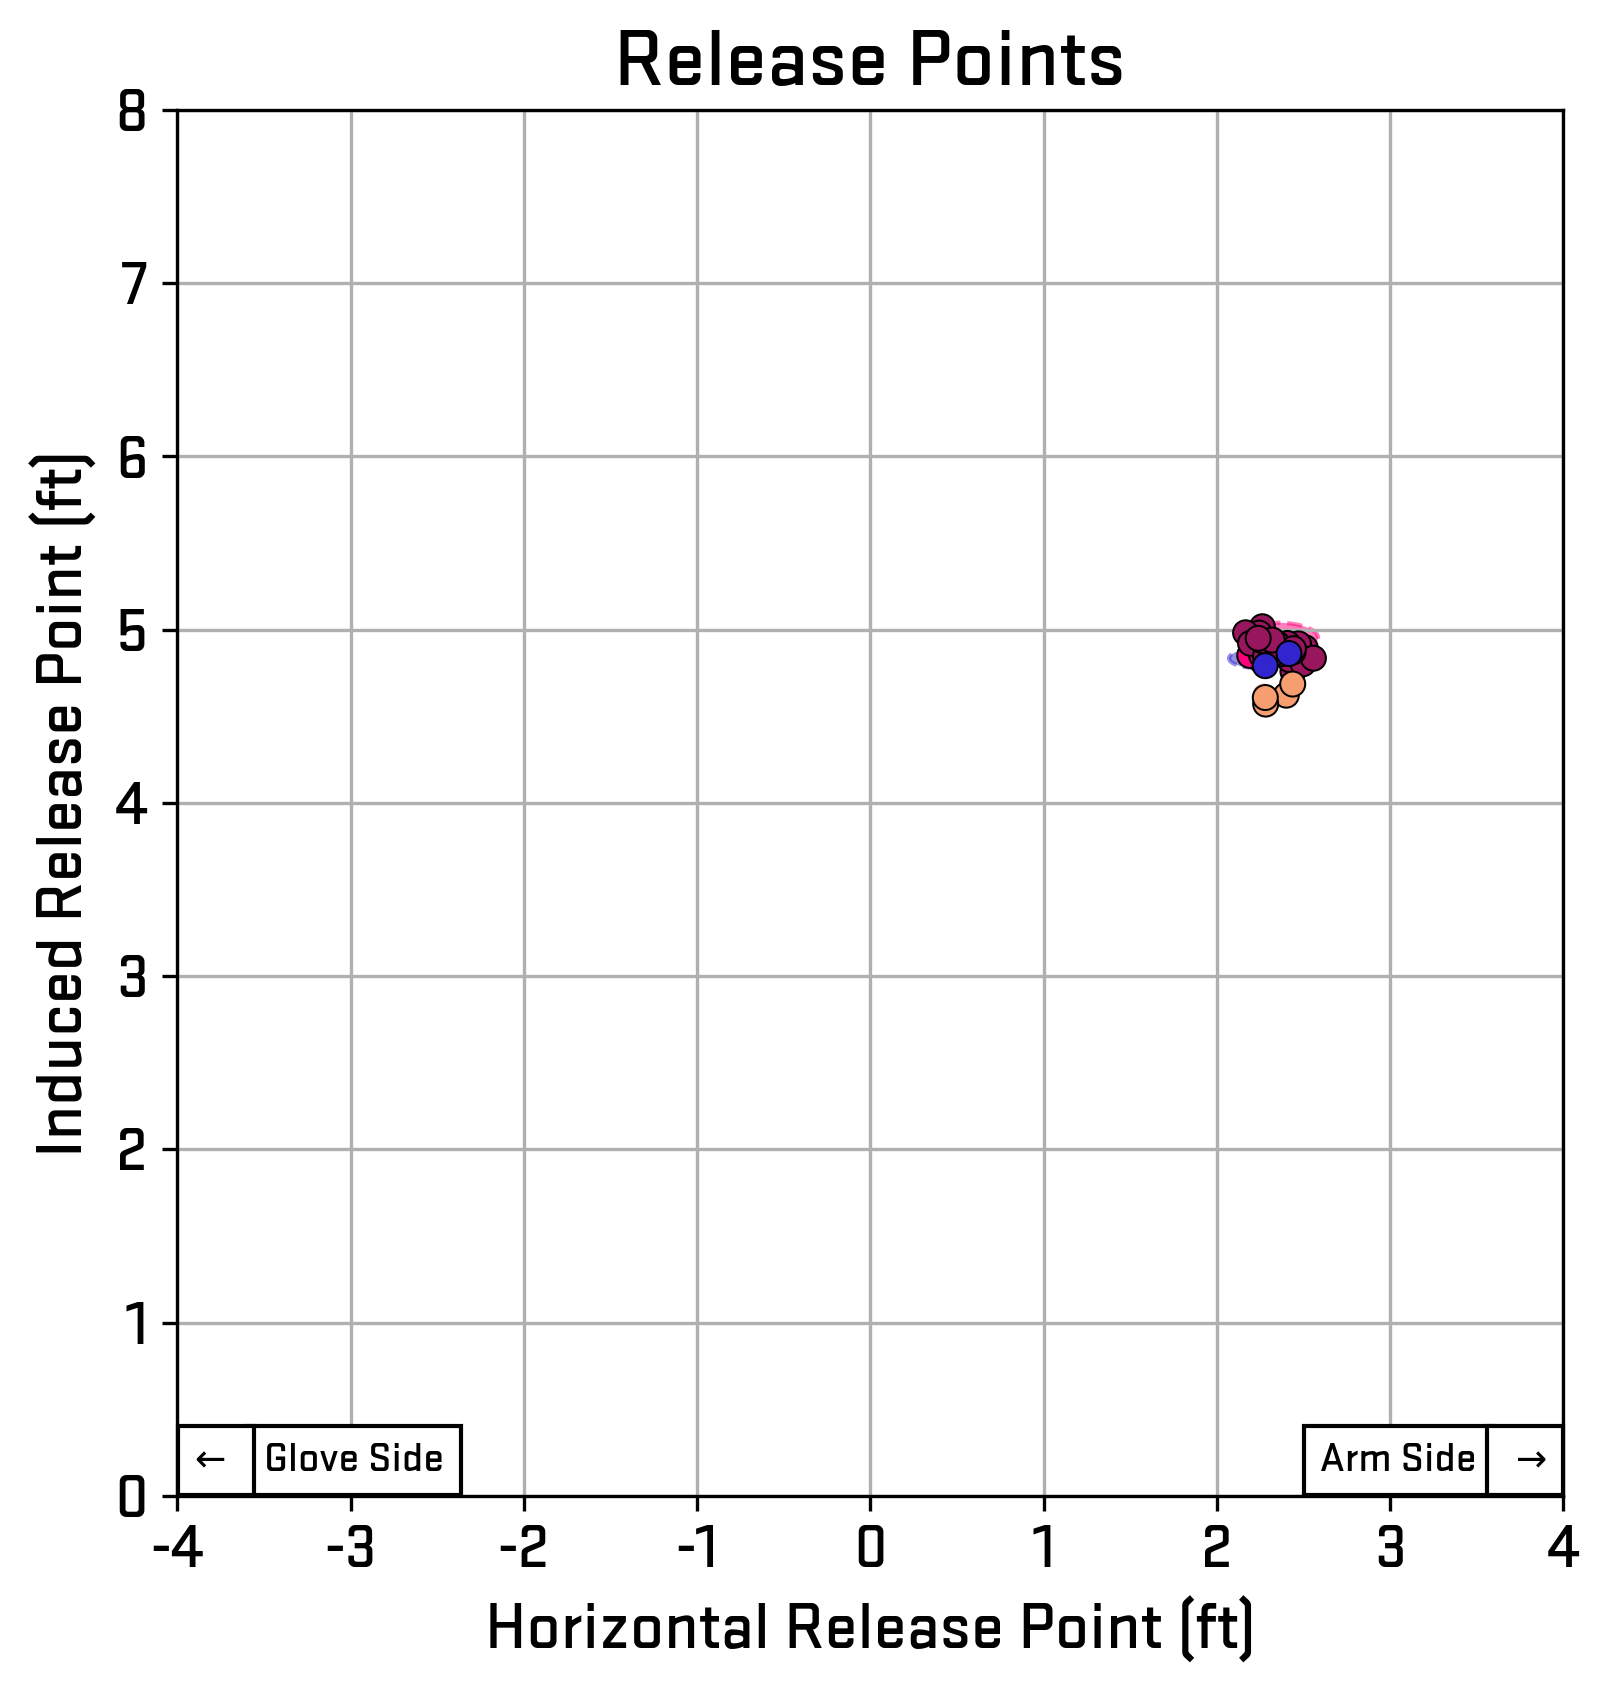

In [ ]:
def release_plot(df, past_df, ax):
    # Check if the pitcher throws with the right hand
    if df['pitcher_hand'].values[0] == 'R':
        sns.scatterplot(ax=ax,
                        x=df['release_side']*-1,
                        y=df['release_height'],
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=5)

    # Check if the pitcher throws with the left hand
    if df['pitcher_hand'].values[0] == 'L':
        sns.scatterplot(ax=ax,
                        x=df['release_side']*-1,
                        y=df['release_height'],
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=3)

    # Finding the mean and sd of the past session's movements
    ellipse_data = past_df.groupby('pitch_type').agg(
        vrel_mean = ('release_height','mean'),  # Average release height
        vrel_sd = ('release_height','std'),  # Standard deviation of release height
        hrel_mean = ('release_side','mean'),  # Average release side
        hrel_sd = ('release_side','std'),  # Standard deviation of release side
        ).fillna(0).reset_index()

    for i in ellipse_data['pitch_type']:
        loc = ellipse_data[ellipse_data['pitch_type'] == i]
        col = dict_color[i]
        ax.add_patch(Ellipse((-loc['hrel_mean'].iloc[0], loc['vrel_mean'].iloc[0]), 2 * loc['hrel_sd'].iloc[0], 2 * loc['vrel_sd'].iloc[0], edgecolor=col, facecolor=col, linestyle='--', alpha=0.5))

    # Set the labels for the x and y axes
    ax.set_xlabel('Horizontal Release Point (ft)', font=stratum, fontsize=16)
    ax.set_ylabel('Induced Release Point (ft)', font=stratum, fontsize=16)

    # Set the title of the plot
    ax.set_title("Release Points", font=stratum, fontsize=20)

    # Remove the legend
    ax.get_legend().remove()

    # Set the tick positions and labels for the x and y axes
    ax.set_xticks(range(-4, 5))
    ax.set_xticklabels(range(-4, 5), font=stratum, fontsize=15)
    ax.set_yticks(range(0, 9))
    ax.set_yticklabels(range(0, 9), font=stratum, fontsize=15)
    ax.grid(zorder=1)

    # Set the limits for the x and y axes
    ax.set_xlim((-4, 4))
    ax.set_ylim((0, 8))

    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal', adjustable='box')

    # Add text annotations based on the pitcher's throwing hand
    if df['pitcher_hand'].values[0] == 'R':
        ax.text(-3.5, 0.1, s='Glove Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-3.9, 0.1, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(3.5, 0.1, s='Arm Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(3.655, 0.1, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    if df['pitcher_hand'].values[0] == 'L':
        ax.text(-3.5, 0.1, s='Arm Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-3.9, 0.1, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(3.5, 0.1, s='Glove Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(3.655, 0.1, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    # Format the x and y axis tick labels as integers
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

release_plot(df=df_2, past_df=df_1, ax=plt.subplots(figsize=(6, 6))[1])

#### Vertical Separation Plot

Inspired by the work of [Maxwell Resnick](https://x.com/MaxwellResnick/status/1853859970632270238/photo/1) and [Jacob](https://x.com/JacobE_STL/status/1875227488202457334/photo/1), I wanted to create a chart showing the angles over time that every pitch has, which shows the angle that a hitter might see and can be key to identifying what a hitter guesses that a pitch is

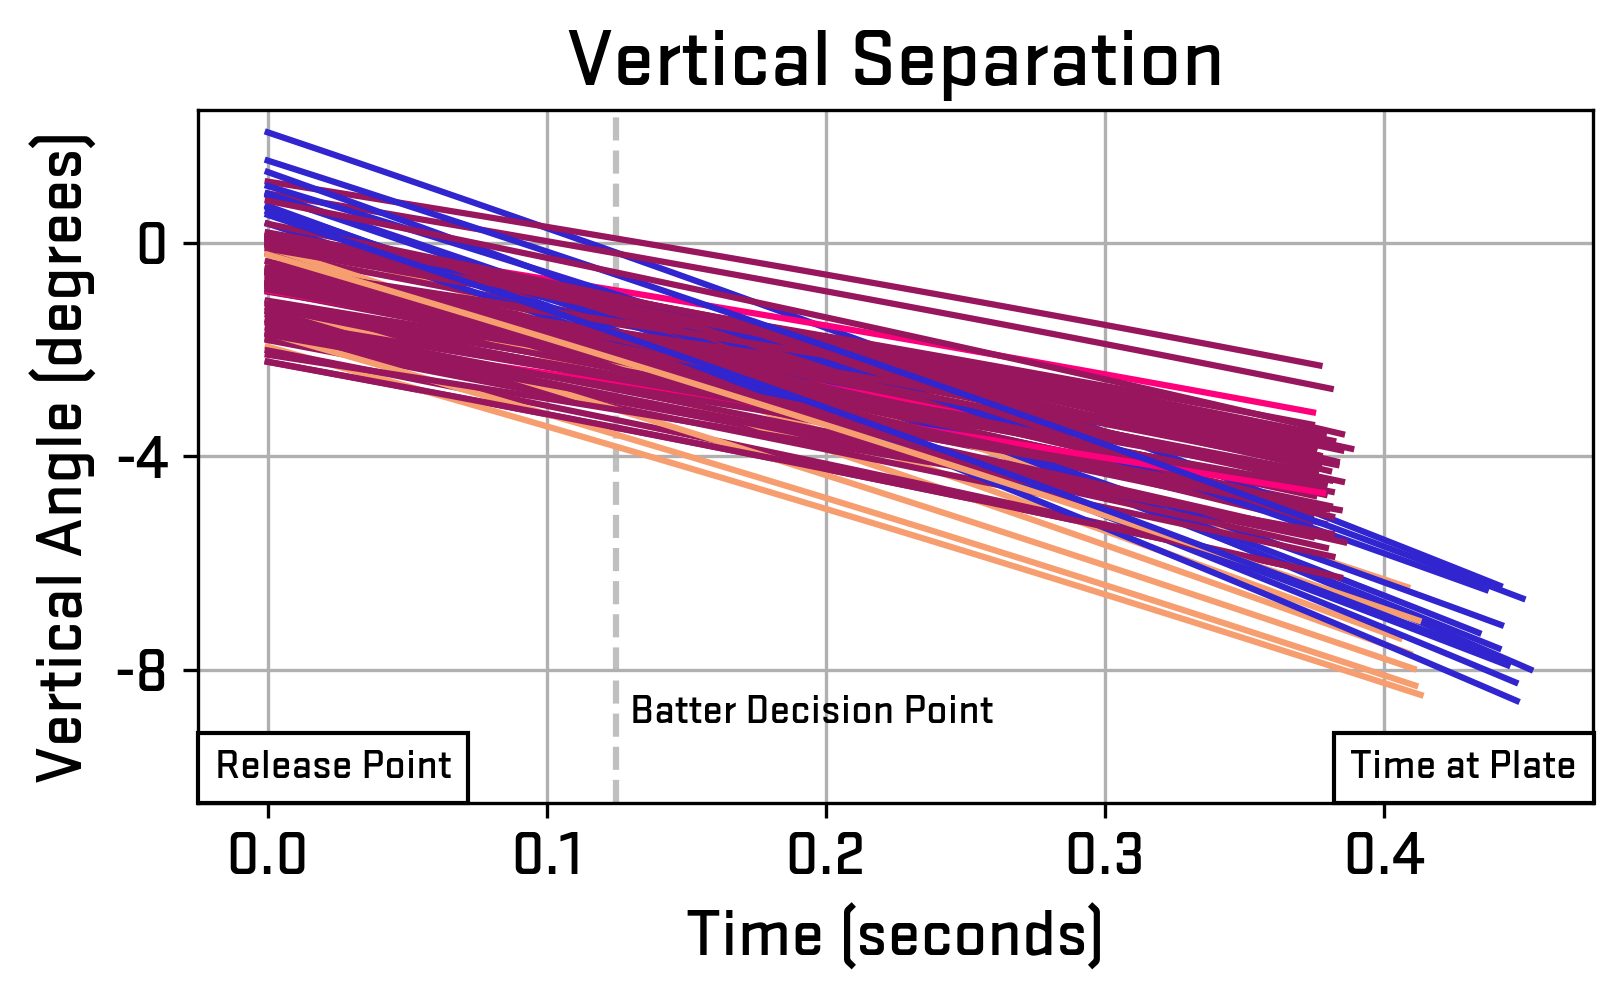

In [ ]:
def vs_plot(df, ax):

    # Plotting the trajectory of each pitch in the sample
    for i, v in df.iterrows():
        x = np.linspace(0,v['t'])
        ax.plot(x,-np.arctan((v['vz0']+v['az']*x)/(v['vy0']+v['ay']*x)) * (180 / np.pi), color=dict_color[v['pitch_type']])

    # Set the labels for the x and y axes
    ax.set_xlabel('Time (seconds)', font=stratum, fontsize=16)
    ax.set_ylabel('Vertical Angle (degrees)', font=stratum, fontsize=16)

    # Set the tick positions and labels for the x and y axes
    ax.set_xticks([x / 10 for x in range(0, 5, 1)])
    ax.set_xticklabels([x / 10 for x in range(0, 5, 1)], font=stratum, fontsize=15)
    ax.set_yticks(range(-8, 3, 4))
    ax.set_yticklabels(range(-8, 3, 4), font=stratum, fontsize=15)
    ax.grid(zorder=1)

    # Set the limits for the x and y axes
    ax.set_xlim((-0.025, 0.475))
    ax.set_ylim((-10.5, 2.5))

    # Draw horizontal line at the decision point, and annotate it
    ax.axvline(x=0.125, color='#808080', alpha=0.5, linestyle='--', zorder=1)
    ax.text(x=0.13, y=-9, s='Batter Decision Point', font=stratum, color='black', fontsize=10, zorder=2)

    # Adding Labels for the plate and release point, for clarity
    ax.text(-0.019, -10.18, s='Release Point', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
    ax.text(0.388, -10.18, s='Time at Plate', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)

    # Set the title of the plot
    ax.set_title("Vertical Separation", font=stratum, fontsize=20)

vs_plot(df=df_2, ax=plt.subplots(figsize=(6, 3))[1])

#### Horizontal Separation Plot

This is very similar to the vertical separation plot, but on the other axis, so this will show the separation especially of sweepers and other lateral moving pitches.

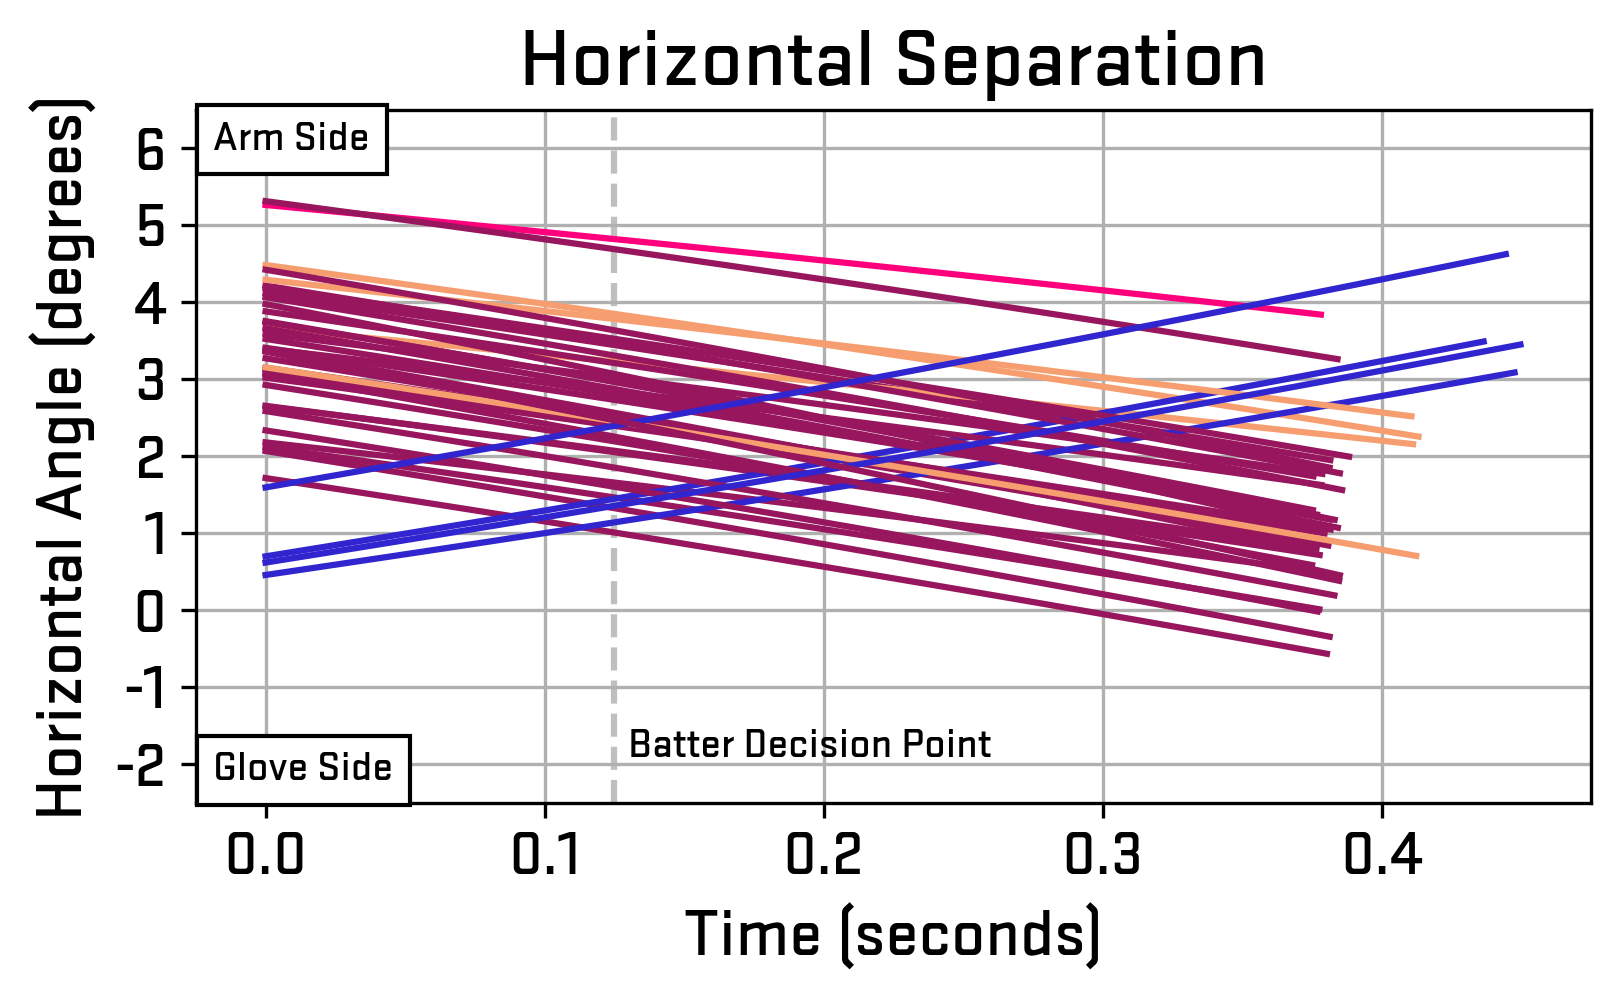

In [ ]:
def hs_plot(df, ax):

    # Plotting the trajectory of each pitch in the sample
    for i, v in df.iterrows():
        x = np.linspace(0,v['t'])
        ax.plot(x,-np.arctan((v['vx0']+v['ax']*x)/(v['vy0']+v['ay']*x)) * (180 / np.pi), color=dict_color[v['pitch_type']])

    # Set the labels for the x and y axes
    ax.set_xlabel('Time (seconds)', font=stratum, fontsize=16)
    ax.set_ylabel('Horizontal Angle (degrees)', font=stratum, fontsize=16)

    # Find averages so the plot can scale to each pitcher
    lowerbound = np.floor(min(df['HAA'])).astype(int) - 1
    upperbound = np.ceil(max(df['HAA'])).astype(int) + 1

    # Set the tick positions and labels for the x and y axes
    ax.set_xticks([x / 10 for x in range(0, 5, 1)])
    ax.set_xticklabels([x / 10 for x in range(0, 5, 1)], font=stratum, fontsize=15)
    ax.set_yticks(range(lowerbound, upperbound+1, 1))
    ax.set_yticklabels(range(lowerbound, upperbound+1, 1), font=stratum, fontsize=15)
    ax.grid(zorder=1)

    # Set the limits for the x and y axes
    ax.set_xlim((-0.025, 0.475))
    ax.set_ylim((lowerbound-0.5, upperbound+0.5))

    # Draw horizontal line at the decision point, and annotate it
    ax.axvline(x=0.125, color='#808080', alpha=0.5, linestyle='--', zorder=1)
    ax.text(x=0.13, y=lowerbound+.1, s='Batter Decision Point', font=stratum, color='black', fontsize=10, zorder=2)

    # Add text annotations based on the pitcher's throwing hand
    if df['pitcher_hand'].values[0] == 'R':
        ax.text(-0.0187, lowerbound - 0.31, s='Glove Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-0.0187, upperbound - 0.12, s='Arm Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)

    if df['pitcher_hand'].values[0] == 'L':
        ax.text(-0.0187, lowerbound - 0.31, s='Arm Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-0.0187, upperbound - 0.12, s='Glove Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)

    # Set the title of the plot
    ax.set_title("Horizontal Separation", font=stratum, fontsize=20)

hs_plot(df=df_2, ax=plt.subplots(figsize=(6, 3))[1])

## Bio Information

Similar to the previous plots, we will include a headshot, title, and beaver logo. Like last time, we'll need to get a link to look up their information first.

In [ ]:
# Defining a command that will return our selected pitcher's OSU roster page
def get_player_link(playername, year):
    # URL of the OSU Beavers baseball roster page
    url = 'https://osubeavers.com/sports/baseball/roster/' + str(year) + '/'

    # Defining a function using Selenium to scroll the page, so it loads every player (original URL stops after loading 30)
    driver = gs.Chrome()
    def scroll_and_scrape(url, scroll_pause_time=1):
        driver.get(url)
        # Get scroll height
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            # Scroll down to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            # Wait to load page
            time.sleep(scroll_pause_time)
            # Calculate new scroll height and compare with last scroll height
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height
        # Now that the page is fully scrolled, grab the source
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        return soup
    soup = scroll_and_scrape(url)

    link = url.removesuffix('/sports/baseball/roster/' + str(year) + '/') + soup.find(attrs={"aria-label": re.compile(playername.replace('.',''))})['href']
    return link

# Returning the link with Selenium takes some time, so for this example we will define the link so it is only called once
ex_link = get_player_link('Eric Segura', 2024)

# Defining a function that will return our selected pitcher's OSU player ID
def get_player_id(playername, link):
    playername = playername.replace(' ', '-')
    id = link.removeprefix('https://osubeavers.com/sports/baseball/roster/' + playername.lower().split(' ',)[0] + '-' + playername.lower().split(' ',)[1] + '/')
    return id

<IPython.core.display.Javascript object>

### Headshot

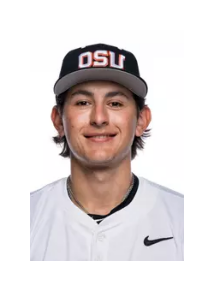

In [ ]:
def get_headshot(link, ax):
    # Using the players link to create a soup object
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')
    # Finding the headshot on the page
    pic_link = soup.find(loading="eager", class_="block aspect-[2/3] h-full w-full max-w-[120px] md:max-w-[180px]")['src']
    # Making the headshot a plottable image
    pic_response = requests.get(pic_link)
    img = Image.open(BytesIO(pic_response.content))
    # Creating the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.5)
    ax.imshow(img, extent=[0, 1, 0, 1.5], origin='upper')
    ax.axis('off')

get_headshot(ex_link, ax=plt.subplots(figsize=(1, 1))[1])

### Title/Bio

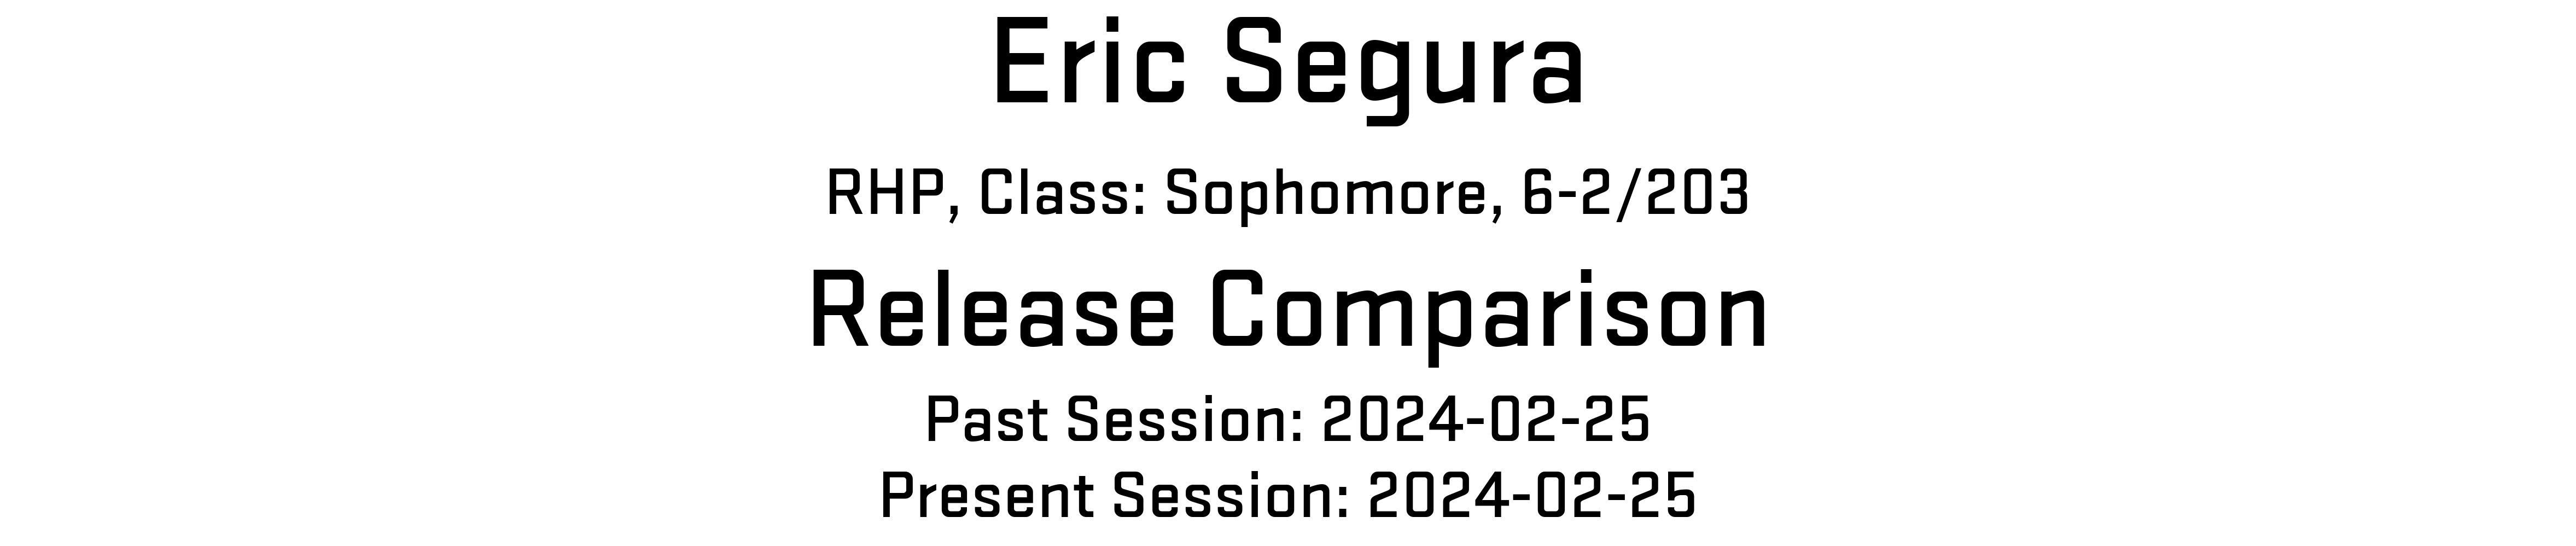

In [ ]:
def title_bio(playername, date_current, date_past, link, ax, plt_type):
    # Using the players link to create a soup object
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')
    # Determining pitcher handedness
    if soup.find("dt", string="Position: ").find_parent().get_text().split(': ')[1].split('-')[0] == "Right":
      pitcher_hand = 'RHP'
    else:
      pitcher_hand = 'LHP'
    # Calling pitcher class
    pitcher_class = soup.find("dt", string="Class: ").find_parent().get_text()
    # Calling height/weight
    height = soup.find("dt", string="Height: ").find_parent().get_text().split(': ')[1]
    weight = soup.find("dt", string="Weight: ").find_parent().get_text().split(': ')[1]
    # Display the graphic
    ax.text(0.5, 1, f'{playername}', va='top', ha='center', fontsize=56, font=stratum)
    ax.text(0.5, 0.70, f'{pitcher_hand}, {pitcher_class}, {height}/{weight}', va='top', ha='center', fontsize=30, font=stratum)
    ax.text(0.5, 0.50, f'{plt_type} Comparison', va='top', ha='center', fontsize=50, font=stratum)
    ax.text(0.5, 0.25, f'Past Session: {date_past}', va='top', ha='center', fontsize=30, fontstyle='italic', font=stratum)
    ax.text(0.5, 0.1, f'Present Session: {date_current}', va='top', ha='center', fontsize=30, fontstyle='italic', font=stratum)

    ax.axis('off')

title_bio('Eric Segura', '2024-02-25', '2024-02-25', ex_link, plt.subplots(figsize=(20, 4))[1], 'Release')

### OSU Logo

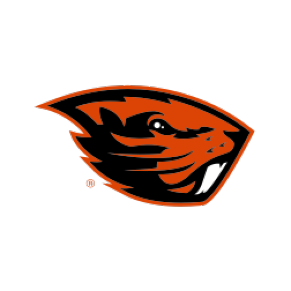

In [ ]:
def logo(ax):
    # Using the logo from the baseball website, but storing it here so we don't have to scrape as it will be the same for each player
    logo_link = 'https://dxbhsrqyrr690.cloudfront.net/sidearm.nextgen.sites/oregonstate.sidearmsports.com/images/logos/site/site.png'
    # Making the logo a plottable image
    logo_response = requests.get(logo_link)
    img = Image.open(BytesIO(logo_response.content))
    # Creating the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')
    ax.axis('off')

logo(ax=plt.subplots(figsize=(1, 1))[1])

## Making the Data Table

These data tables will display the selected metrics, and compare them to the same metrics in the previous pitching session. We will first create them as a dataframe, then define some color maps, then generate the final table as a plot.

### Dataframe

In [ ]:
# Defining a function to group dataframes by pitch type and display relevant metrics for each plot
def tm_grouping_mvt(df: pd.DataFrame):
    df_group = df.groupby(['pitcher_name','pitch_type']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                        spin_rate = ('spin_rate','mean'),  # Average spin rate
                        spin_axis = ('spin_axis','mean'),  # Average spin axis
                        ivb = ('ivb','mean'),  # Average vertical movement
                        hb = ('hb','mean'),  # Average horizontal movement
                        VAA = ('VAA','mean'),  # Average vertical approach angle
                        HAA = ('HAA','mean')  # Average horizontal approach angle
                        ).reset_index()
    df_group = df_group.sort_values(by='pitch', ascending=False).reset_index(drop=True)
    return df_group

def tm_grouping_rel(df: pd.DataFrame):
    df_group = df.groupby(['pitcher_name','pitch_type']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                        release_speed = ('release_speed','mean'),  # Average start speed
                        release_height = ('release_height','mean'),  # Average vertical release position
                        release_side = ('release_side','mean'),  # Average horizontal release position
                        extension = ('extension','mean'),  # Average release extension
                        VRA = ('VRA','mean'),  # Average vertical release angle
                        HRA = ('HRA','mean'),  # Average horizontal release angle
                        ).reset_index()
    df_group = df_group.sort_values(by='pitch', ascending=False).reset_index(drop=True)
    return df_group

# Defining a function to take our raw dfs, group them, and combine them into one dataframe
def combined_df(current_df, past_df, plt_type):
    # Applying the right grouping formula
    if plt_type == 'Movement':
        df2 = tm_grouping_mvt(current_df)
        df1 = tm_grouping_mvt(past_df)
        rename_columns = ['pitch', 'spin_rate', 'spin_axis', 'ivb', 'hb', 'VAA', 'HAA']

    if plt_type == 'Release':
        df2 = tm_grouping_rel(current_df)
        df1 = tm_grouping_rel(past_df)
        rename_columns = ['pitch', 'release_speed', 'release_height', 'release_side', 'extension', 'VRA', 'HRA']

    # Renaming the columns in the past data
    df1_ren = df1[rename_columns].add_suffix('_past')
    df1_new = pd.concat([df1[['pitcher_name', 'pitch_type']], df1_ren], axis=1)

    # Combining the data into one dataframe
    df = pd.merge(df2, df1_new, on=['pitcher_name', 'pitch_type'], how='left')

    # Adding relevant columns
    df['pitch_description'] = df['pitch_type'].map(dict_pitch)
    df['color'] = df['pitch_type'].map(dict_color)
    color_list = df['color'].tolist()

    # Shortening the df to just what's necessary
    order1 = [[x, x + '_past'] for x in rename_columns]
    order1 = ['pitch_description'] + [item for sublist in order1 for item in sublist]
    df = df[order1]

    return df, color_list

df, col = combined_df(df_2, df_1, 'Movement')

### Color/Formatting

In [ ]:
pitch_stats_dict = {
    'pitch': {'table_header': '$\\bf{Count}$', 'format': '.0f'},
    'release_speed': {'table_header': '$\\bf{Velo}$', 'format': '.1f'},
    'ivb': {'table_header': '$\\bf{iVB}$', 'format': '.1f'},
    'hb': {'table_header': '$\\bf{HB}$', 'format': '.1f'},
    'spin_rate': {'table_header': '$\\bf{Spin}$', 'format': '.0f'},
    'release_side': {'table_header': '$\\bf{hRel}$', 'format': '.1f'},
    'release_height': {'table_header': '$\\bf{vRel}$', 'format': '.1f'},
    'extension': {'table_header': '$\\bf{Ext.}$', 'format': '.1f'},
    'spin_axis': {'table_header': '$\\bf{Spin}$ \n $\\bf{Axis}$', 'format': '.1f'},
    'VAA': {'table_header': '$\\bf{VAA}$', 'format': '.1f'},
    'HAA': {'table_header': '$\\bf{HAA}$', 'format': '.1f'},
    'VRA': {'table_header': '$\\bf{VRA}$', 'format': '.1f'},
    'HRA': {'table_header': '$\\bf{HRA}$', 'format': '.1f'},
    'pitch_past': {'table_header': '$\\bf{Count}$ \n $\\bf{(past)}$', 'format': '.0f'},
    'release_speed_past': {'table_header': '$\\bf{Velo}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'ivb_past': {'table_header': '$\\bf{iVB}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'hb_past': {'table_header': '$\\bf{HB}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'spin_rate_past': {'table_header': '$\\bf{Spin}$ \n $\\bf{(past)}$', 'format': '.0f'},
    'release_side_past': {'table_header': '$\\bf{hRel}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'release_height_past': {'table_header': '$\\bf{vRel}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'extension_past': {'table_header': '$\\bf{Ext.}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'spin_axis_past': {'table_header': '$\\bf{Spin}$ \n $\\bf{Axis}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'VAA_past': {'table_header': '$\\bf{VAA}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'HAA_past': {'table_header': '$\\bf{HAA}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'VRA_past': {'table_header': '$\\bf{VRA}$ \n $\\bf{(past)}$', 'format': '.1f'},
    'HRA_past': {'table_header': '$\\bf{HRA}$ \n $\\bf{(past)}$', 'format': '.1f'}
    }

mvt_columns = [ 'pitch_description',
            'pitch',
            'pitch_past',
            'spin_rate',
            'spin_rate_past',
            'spin_axis',
            'spin_axis_past',
            'ivb',
            'ivb_past',
            'hb',
            'hb_past',
            'VAA',
            'VAA_past',
            'HAA',
            'HAA_past']

rel_columns = ['pitch_description',
            'pitch',
            'pitch_past',
            'release_speed',
            'release_speed_past',
            'release_height',
            'release_height_past',
            'release_side',
            'release_side_past',
            'extension',
            'extension_past',
            'VRA',
            'VRA_past',
            'HRA',
            'HRA_past']

def plot_pitch_format(df_group, table):
    # Apply the formats to the DataFrame
    # Iterate over each column in pitch_stats_dict
    for column, props in pitch_stats_dict.items():
        # Check if the column exists in df_plot
        if column in df_group.columns:
            # Apply the specified format to the column values
            df_group[column] = df_group[column].apply(lambda x: format(x, props['format']) if isinstance(x, (int, float)) else x)
    return df_group

plot_pitch_format(df, mvt_columns)

pitch_description pitch pitch_past spin_rate spin_rate_past spin_axis  \
0            Sinker    32         28      2368           2399     239.8   
1          Changeup     4          3      1844           1875     255.0   
2         Curveball     4          7      2173           2300      59.5   
3   4-Seam Fastball     1          2      2384           2412     241.0   

  spin_axis_past   ivb ivb_past     hb hb_past   VAA VAA_past  HAA HAA_past  
0          239.8  10.6     10.9   12.9    14.2  -4.7     -4.3  1.0      0.9  
1          256.3  -0.0     -2.6   11.3    10.5  -8.0     -7.2  1.9      2.5  
2           60.9  -2.7     -3.5  -15.9   -16.2  -7.4     -7.5  3.7      4.7  
3          234.0  15.2     12.5    8.2     8.6  -4.7     -3.8  3.8      1.4

In [ ]:
# Define color maps
cmap_sum = mcolors.LinearSegmentedColormap.from_list("", ['#325aa1','#FFFFFF','#c91f26'])
cmap_sum_r = mcolors.LinearSegmentedColormap.from_list("", ['#c91f26','#FFFFFF','#325aa1'])

# Get colors
def get_color(value, normalize, cmap_sum):
    color = cmap_sum(normalize(value))
    return mcolors.to_hex(color)

color_stats = ['spin_rate', 'spin_axis', 'ivb', 'hb', 'VAA', 'HAA', 'release_speed', 'release_height', 'release_side', 'extension', 'VRA', 'HRA']

def get_cell_colors(df_group: pd.DataFrame,
                     color_stats: list,
                     table_columns: list,
                     cmap_sum: mcolors.LinearSegmentedColormap,
                     cmap_sum_r: mcolors.LinearSegmentedColormap):
    # Making an empty list to add the colors to
    color_list_df = []

    # Iterating for each pitch type
    for pt in df_group['pitch_description']:
        color_list_df_inner = []
        df_group_select = df_group[df_group['pitch_description'] == pt]

        # Iterating for each column
        for tb in table_columns:

            # Ensuring that the columns should be colored, and that the data is a number
            if tb in color_stats and type(df_group_select[tb].values[0]) == np.float64:
                select_df = df_group_select[df_group_select.columns[df_group_select.columns.getloc(tb) + 1]]

                # Making the color white if the value is NaN
                if np.isnan(df_group_select[tb].values[0]):
                    color_list_df_inner.append('#ffffff')

                # Applying the color
                else:
                    normalize = mcolors.Normalize(vmin=(0.5),
                                                  vmax=(1.5))
                    color_list_df_inner.append(get_color(df_group_select[tb]/select_df, normalize, cmap_sum))
            else:
                color_list_df_inner.append('#ffffff')
        color_list_df.append(color_list_df_inner)
    return color_list_df

### Final Plotted Table

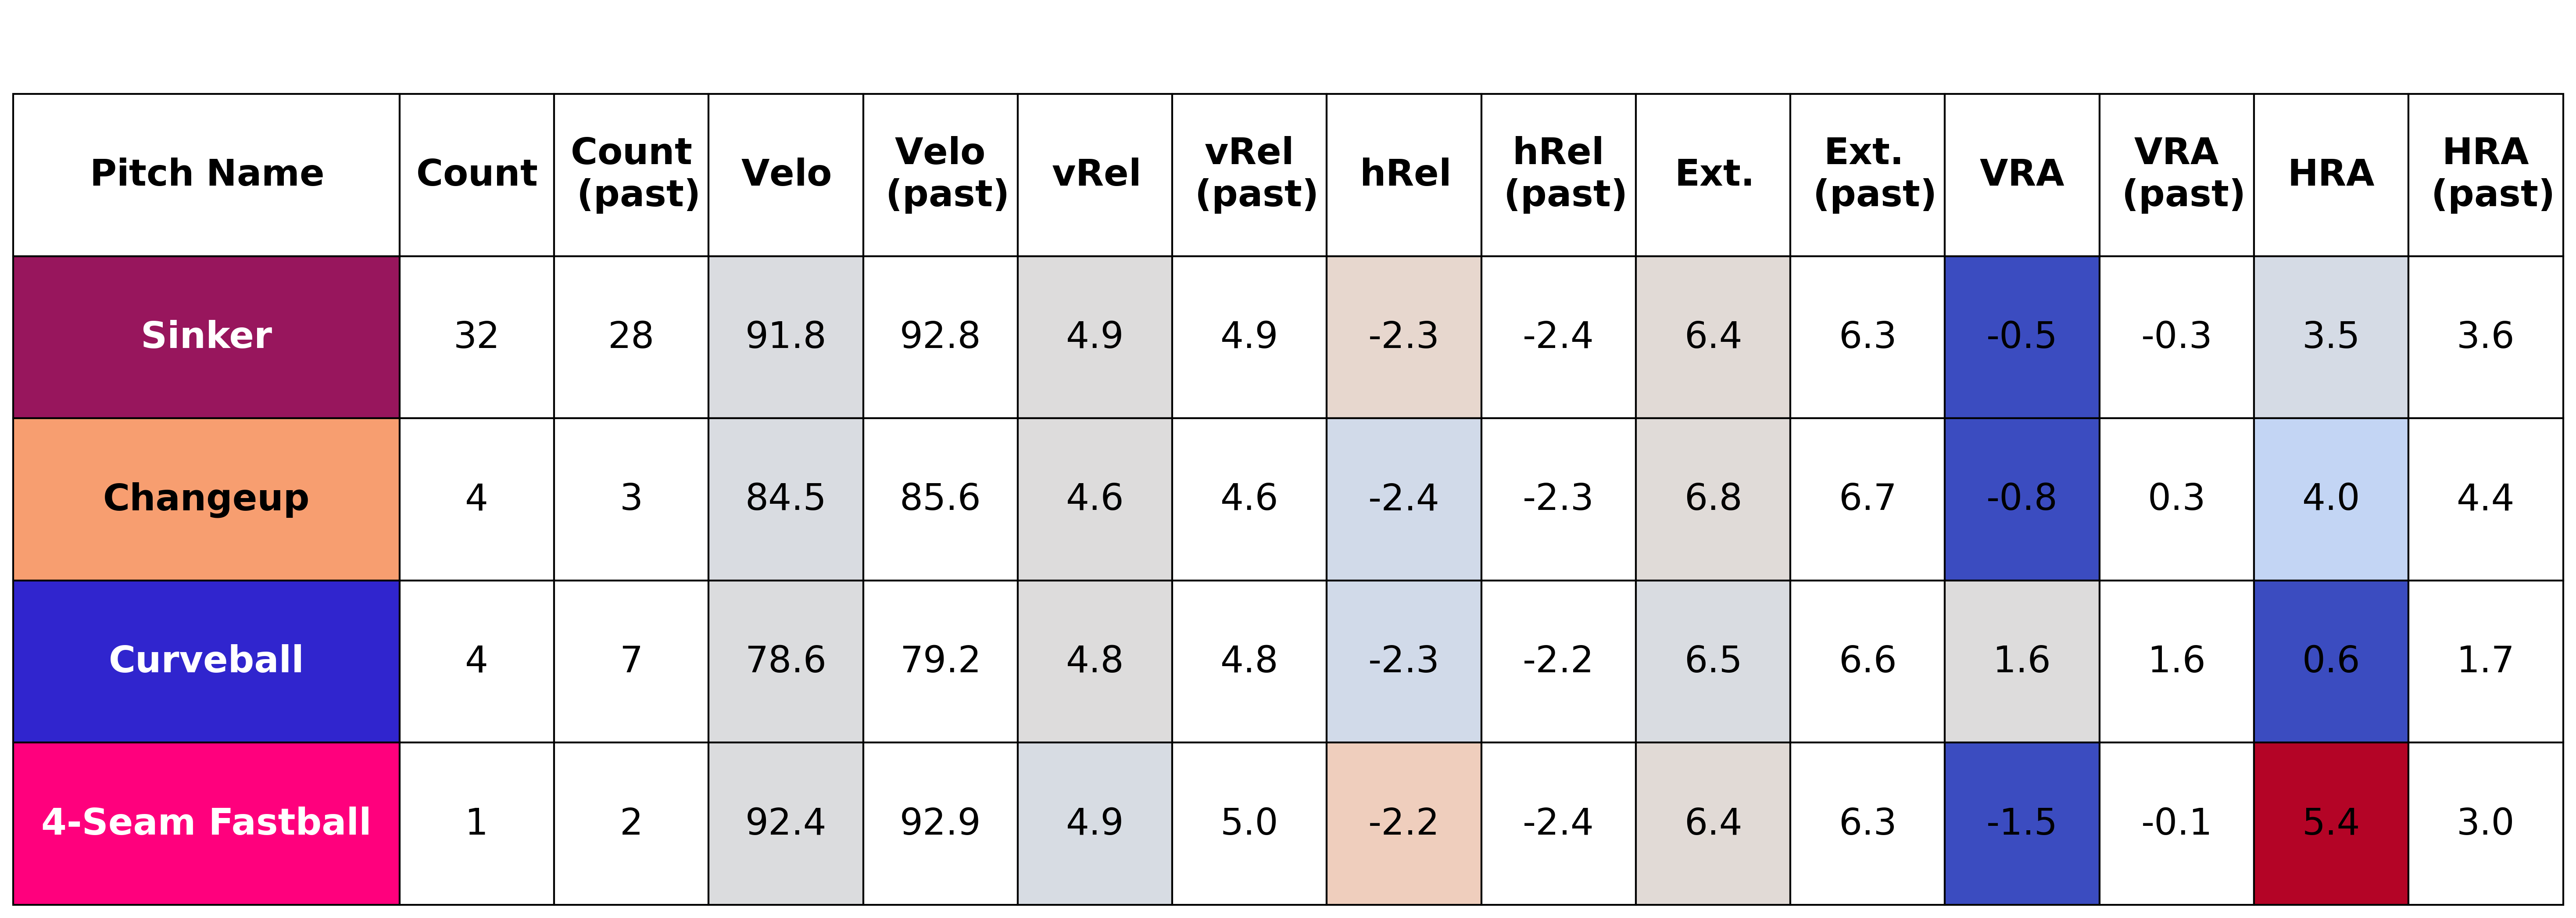

In [ ]:
def metric_comp_table(current_df, past_df, plt_type, ax):

    # Defining what table we want for our pitch formatting function
    if plt_type == 'Movement':
        table_columns = mvt_columns
        color_stats = ['spin_rate', 'spin_axis', 'ivb', 'hb', 'VAA', 'HAA']
    if plt_type == 'Release':
        table_columns = rel_columns
        color_stats = ['release_speed', 'release_height', 'release_side', 'extension', 'VRA', 'HRA']

    # Performing operations on our dataframe
    df_group, color_list = combined_df(current_df, past_df, plt_type)
    df_plot = plot_pitch_format(df_group, table_columns)

    # Create a table plot with the DataFrame values and specified column labels
    table_plot = ax.table(cellText=df_plot.values, colLabels=table_columns, cellLoc='center',
                        bbox=[0, -0.1, 1, 1],
                        colWidths=[2.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

    # Disable automatic font size adjustment and set the font size
    table_plot.auto_set_font_size(False)

    table_plot.set_fontsize(20)

    # Scale the table plot
    table_plot.scale(1, 0.5)

    # Correctly format the new column names using LaTeX formatting
    new_column_names = ['$\\bf{Pitch\\ Name}$'] + [pitch_stats_dict[x]['table_header'] if x in pitch_stats_dict else '---' for x in table_columns[1:]]

    # Update the table headers with the new column names
    for i, col_name in enumerate(new_column_names):
        table_plot.get_celld()[(0, i)].get_text().set_text(col_name)

    # Bold the first column in the table
    for i in range(len(df_plot)):
        table_plot.get_celld()[(i+1, 0)].get_text().set_fontweight('bold')

    # Set the color for the first column, all rows except header and last
    for i in range(1, len(df_plot) + 1):
        # Check if the pitch type is in the specified list
        if table_plot.get_celld()[(i, 0)].get_text().get_text() in ['Split-Finger', 'Slider', 'Changeup']:
            table_plot.get_celld()[(i, 0)].set_text_props(color='#000000', fontweight='bold')
        else:
            table_plot.get_celld()[(i, 0)].set_text_props(color='#FFFFFF')
        # Set the background color of the cell
        table_plot.get_celld()[(i, 0)].set_facecolor(color_list[i-1])

    # Apply the gradient background color for the non-_past columns
    for col in table_columns[1:]:
        if col not in color_stats:
            continue  # Skip columns with '_past'

        # Get the corresponding '_past' column for the difference calculation
        past_col = col + '_past'

        # Calculate the differences between current and past values
        diff = df_plot[col].astype(float) - df_plot[past_col].astype(float)

        # Normalize the differences (you can scale this further if needed)
        norm = (diff) / abs(df_plot[past_col].astype(float)) +.5

        # Apply a color gradient based on the normalized difference
        cmap = plt.get_cmap('coolwarm')  # You can choose other colormaps like 'viridis', 'plasma', etc.

        for i in range(len(df_plot)):
            color = cmap(norm[i])  # Map the normalized difference to a color
            table_plot.get_celld()[(i+1, table_columns.index(col))].set_facecolor(color)

    # Remove the axis
    ax.axis('off')

metric_comp_table(df_2, df_1, 'Release', plt.subplots(figsize=(25, 8))[1])

## Making the Final Graphic

This will generate a function that can create either graphic, as they are very similar, depending on what type is called in the formula.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

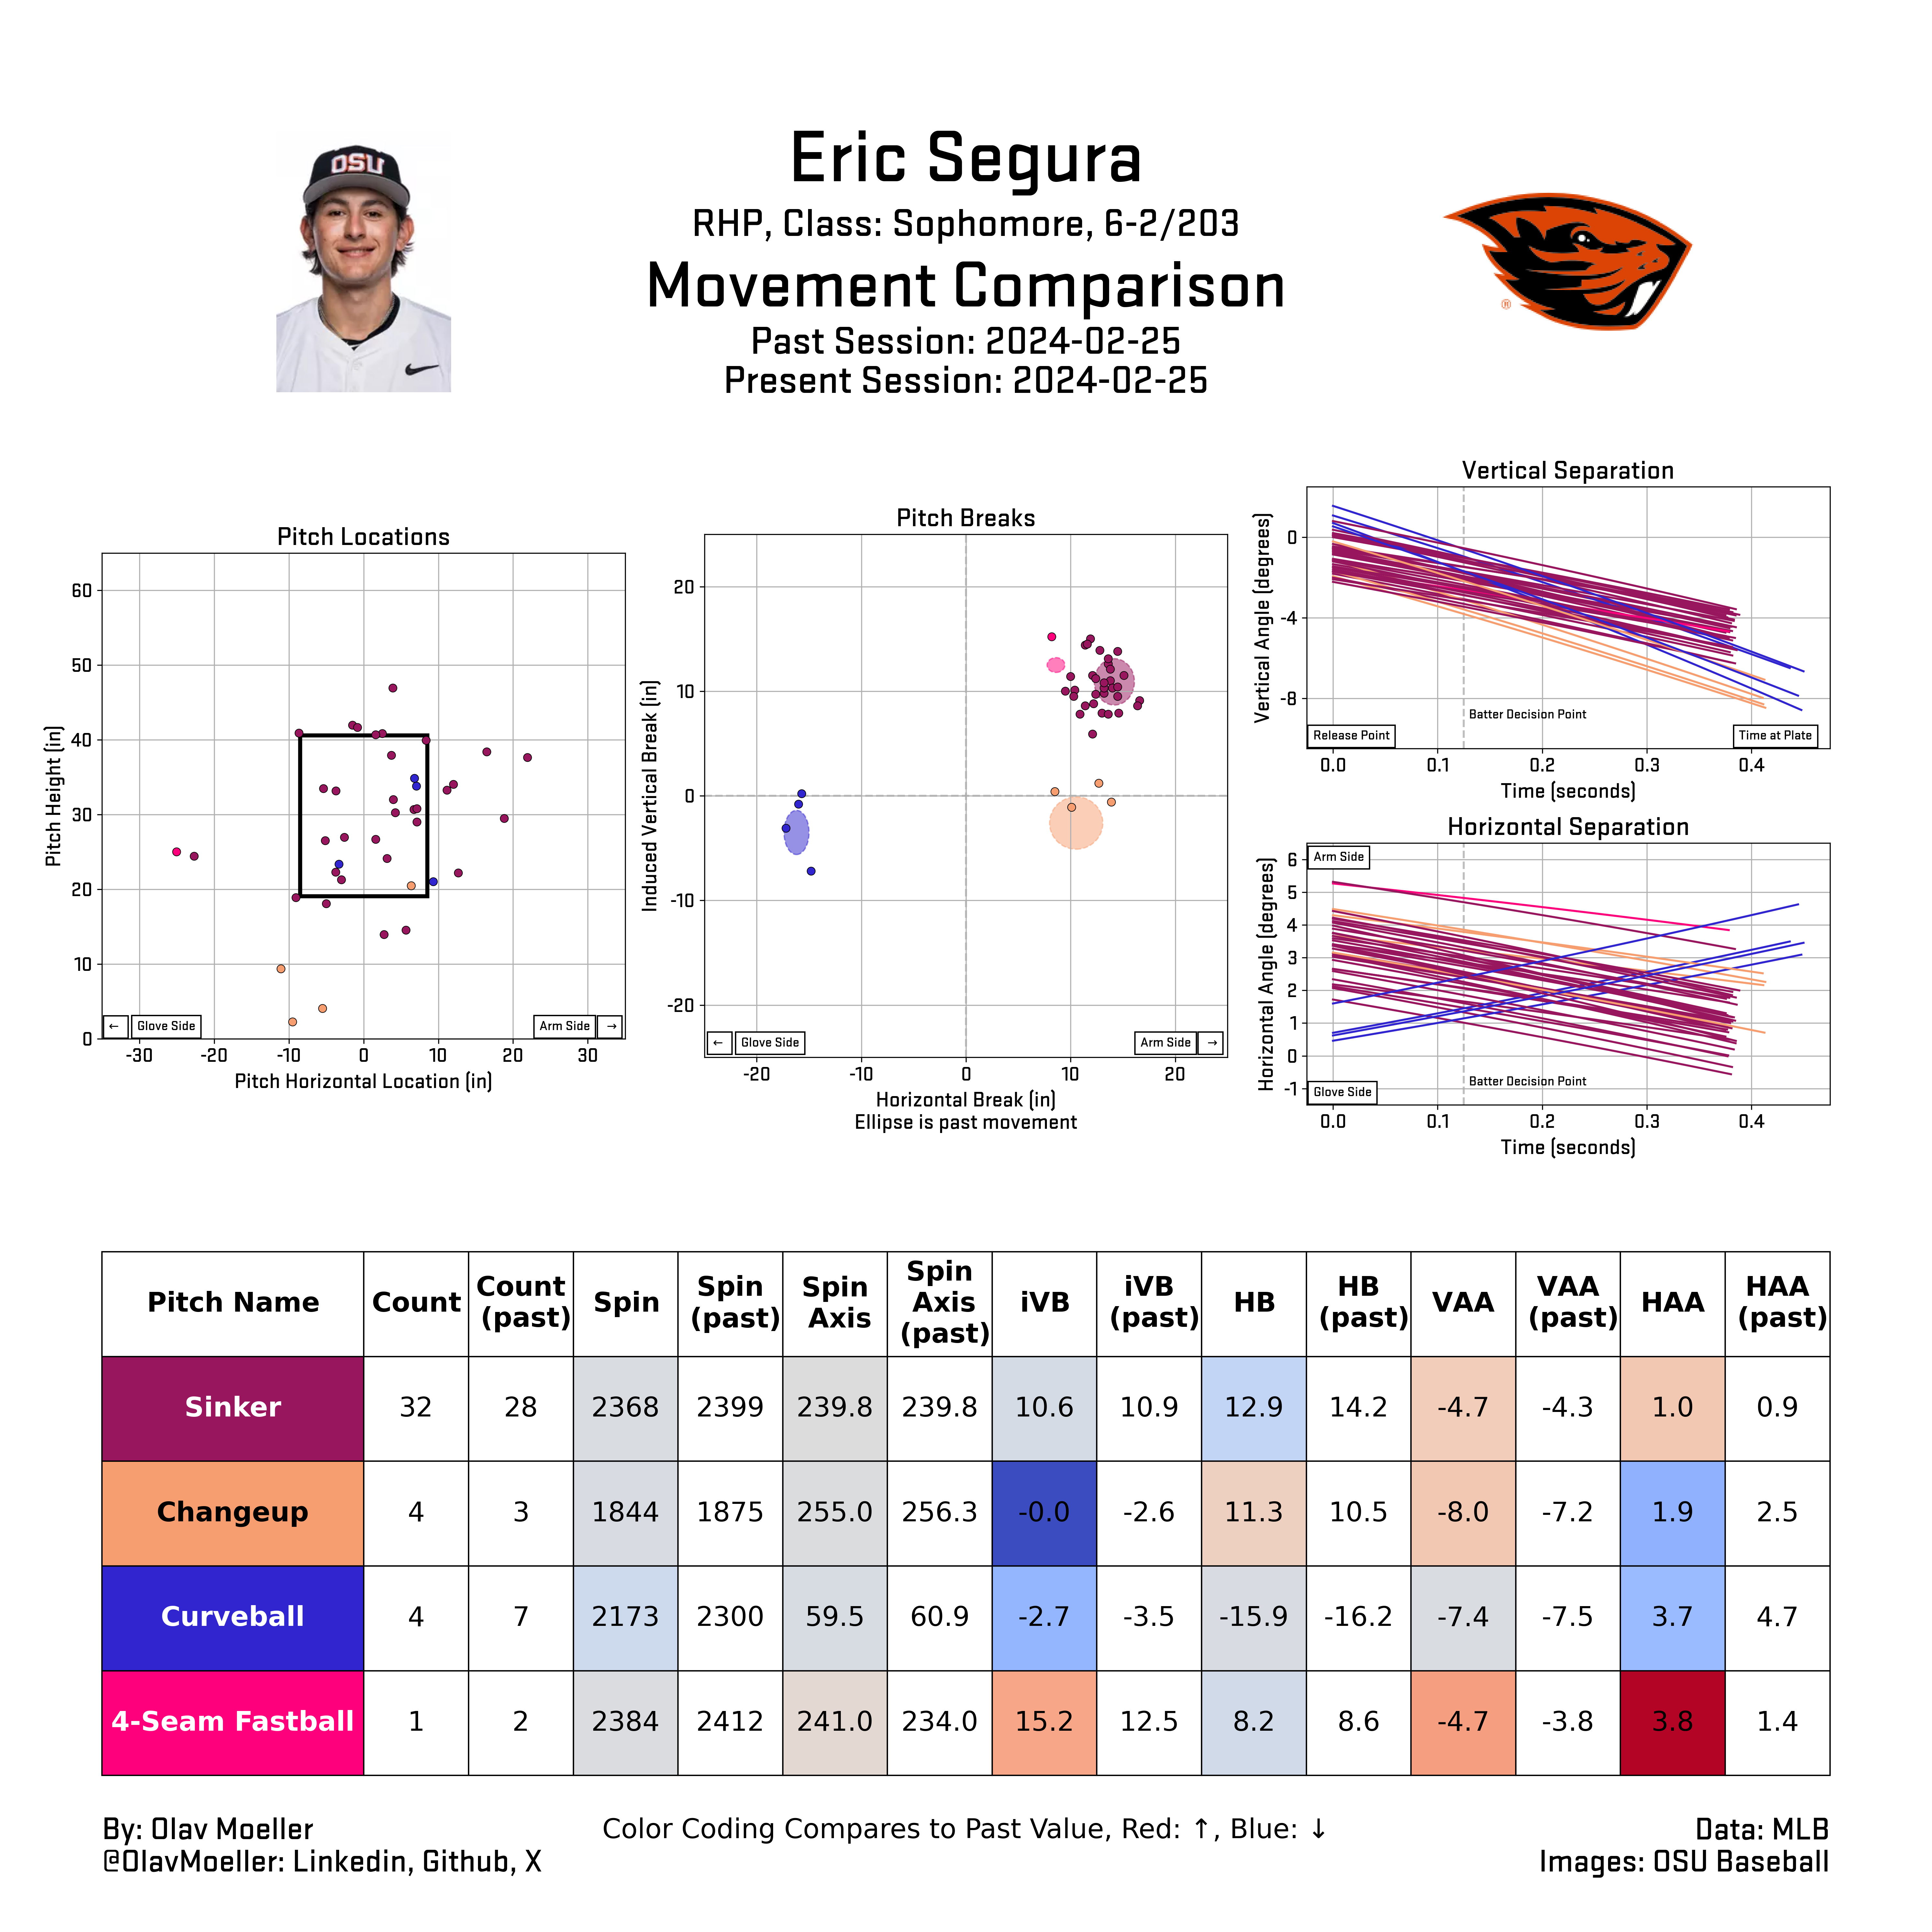

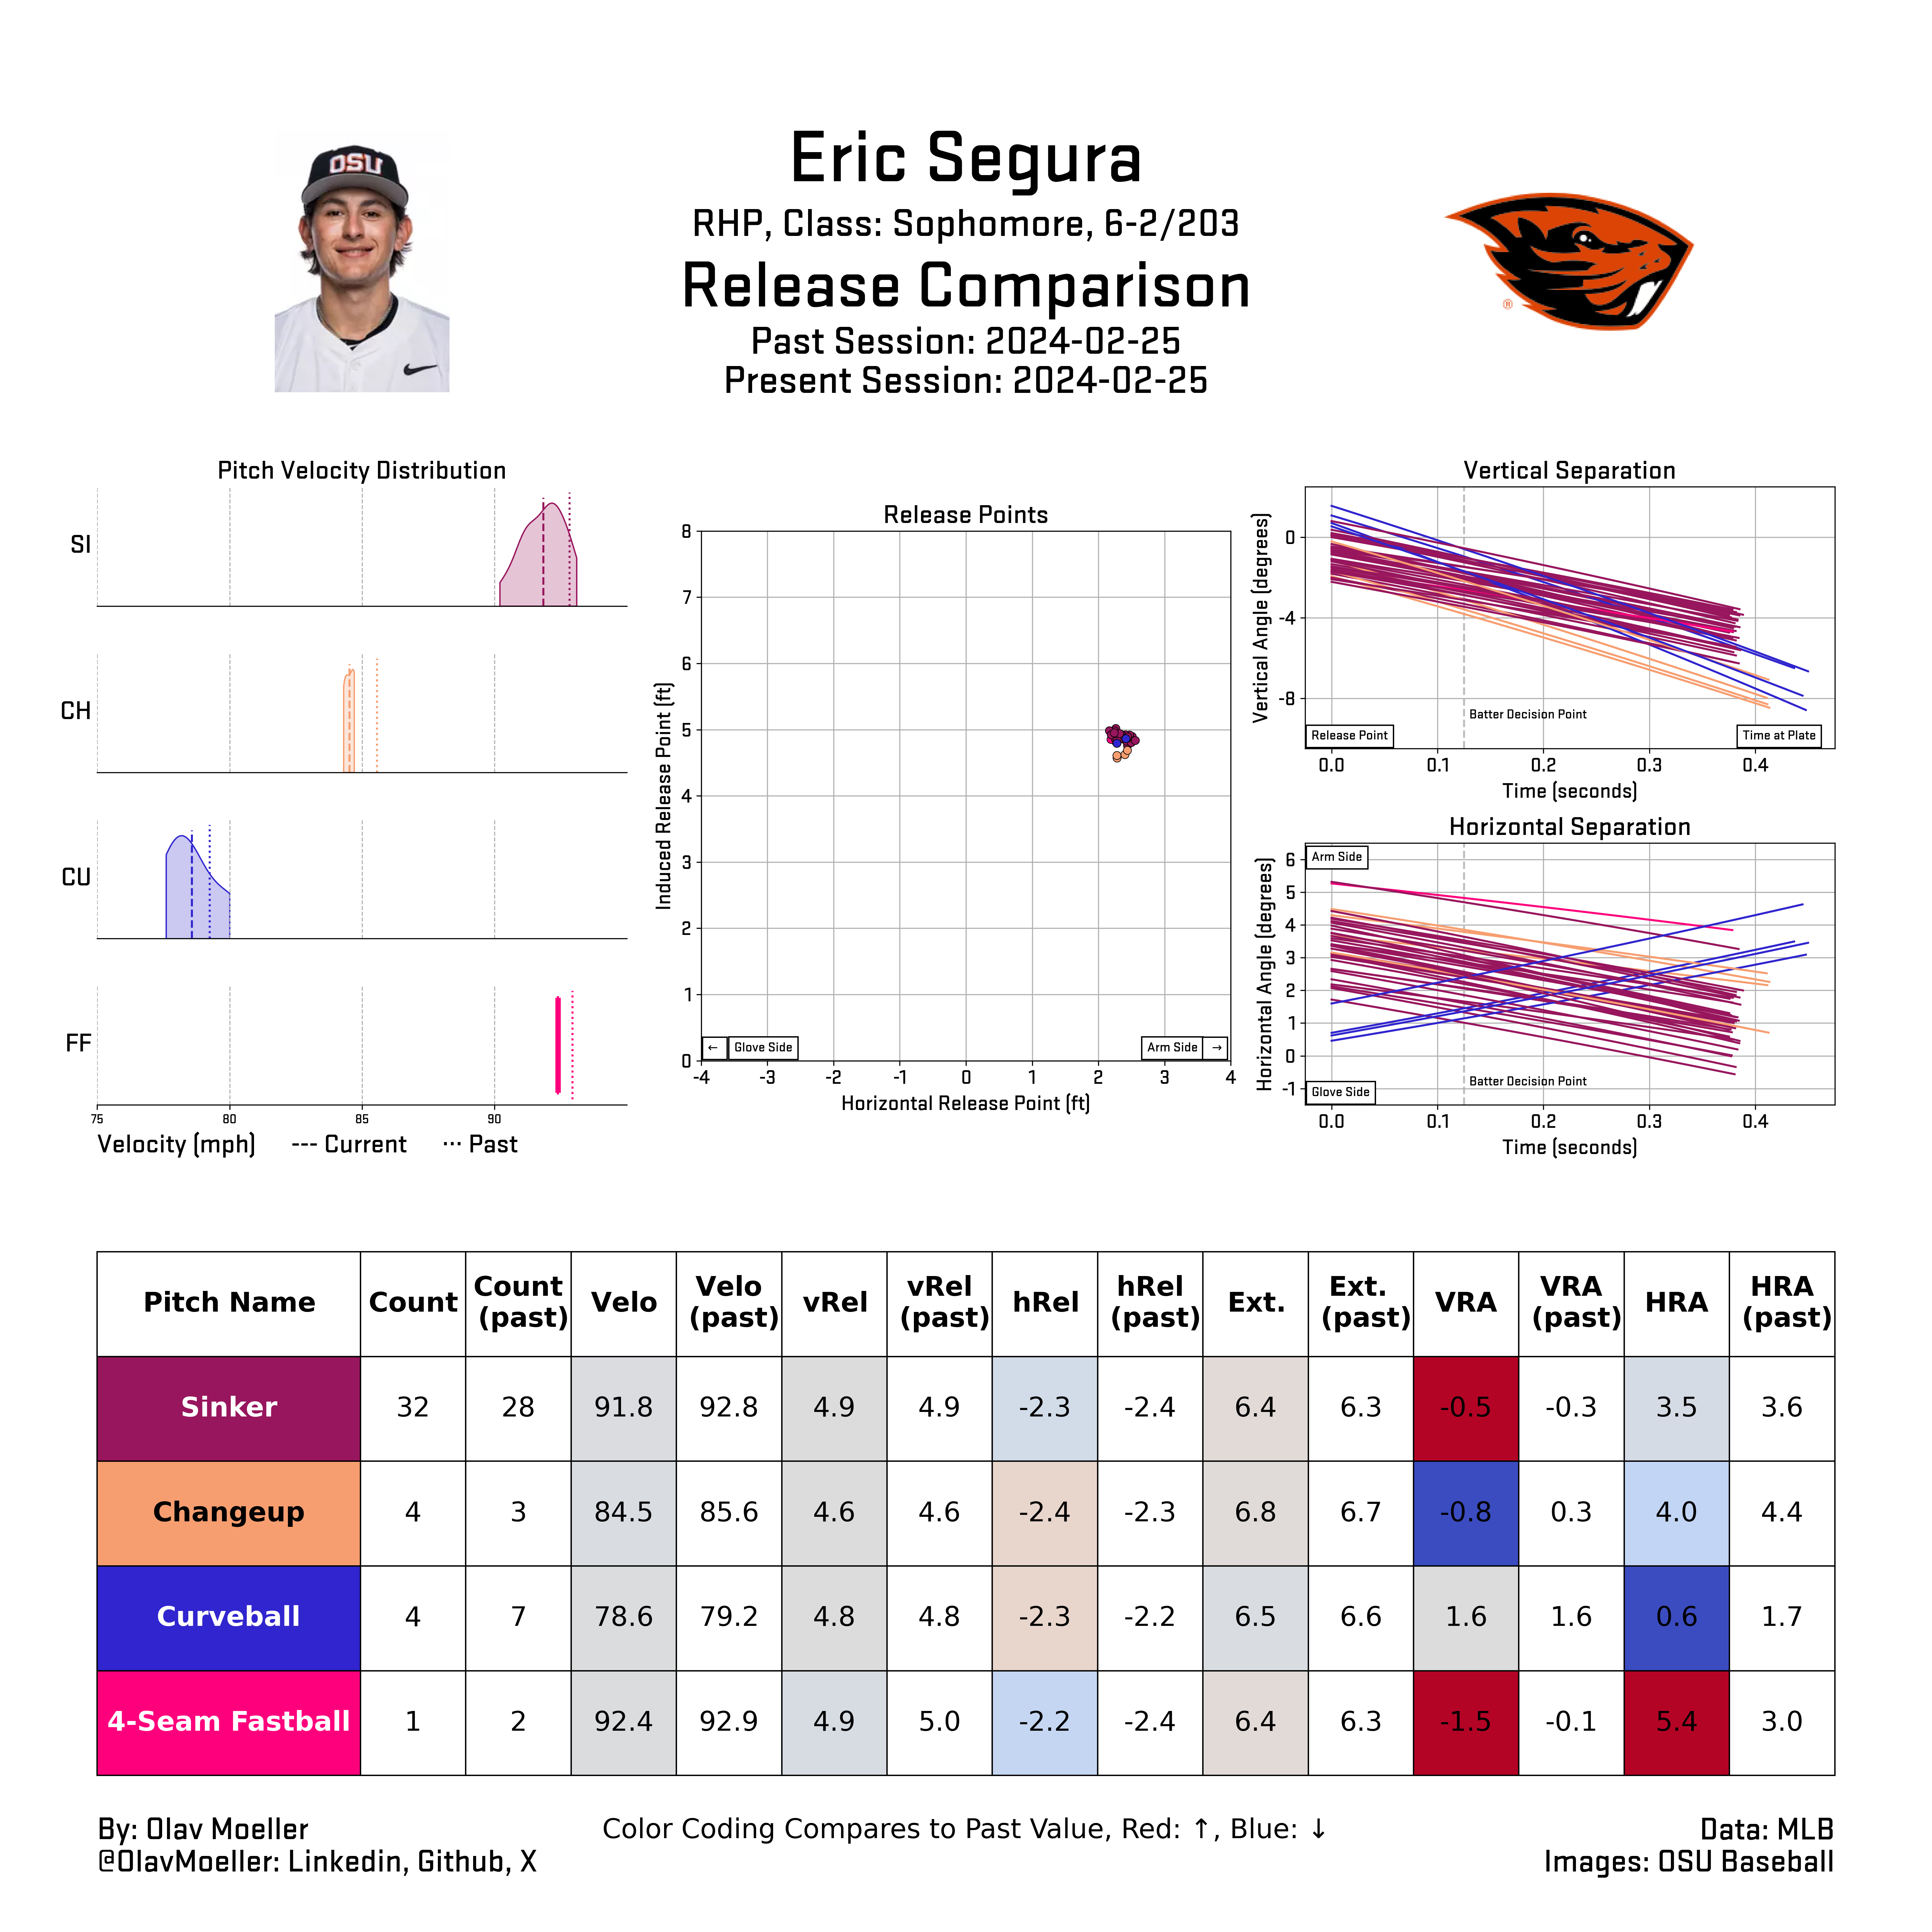

In [ ]:
def practice_comp(df_current, df_past, plt_type):

    # Create a 20 by 20 figure
    fig = plt.figure(figsize=(20, 20))

    # Create a gridspec layout with 5 columns and 6 rows
    # Include border plots for the header, footer, left, and right
    gs = gridspec.GridSpec(6, 5,
                        height_ratios=[2,20,20,20,40,8],
                        width_ratios=[1,40,40,40,1])

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1,1])
    ax_title_bio = fig.add_subplot(gs[1,2])
    ax_logo = fig.add_subplot(gs[1,3])

    ax_plot_1 = fig.add_subplot(gs[2:4,1])
    ax_plot_2 = fig.add_subplot(gs[2:4,2])
    ax_plot_3 = fig.add_subplot(gs[2,3])
    ax_plot_4 = fig.add_subplot(gs[3,3])

    ax_table = fig.add_subplot(gs[4,1:4])

    ax_footer = fig.add_subplot(gs[-1,1:4])
    ax_header = fig.add_subplot(gs[0,1:4])
    ax_left = fig.add_subplot(gs[:,0])
    ax_right = fig.add_subplot(gs[:,-1])

    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Defining some variables
    playername = df_current['pitcher_name'].values[0]
    past_date = df_past['game_date'].values[0]
    current_date = df_current['game_date'].values[0]
    current_year = current_date.split('-')[0]

    # Define the player's link that can be called for the functions
    link = get_player_link(playername, current_year)

    # Call the functions
    get_headshot(link=link, ax=ax_headshot)
    title_bio(playername, current_date, past_date, link, ax_title_bio, plt_type)
    logo(ax=ax_logo)

    # Allow for either type of plot to be called
    if plt_type == 'Release':
        velocity_chart(df=df_current, past_df=df_past, fig=fig, ax=ax_plot_1, gs=gs, gs_x=[2,4], gs_y=[1,2])
        release_plot(df=df_current, past_df=df_past, ax=ax_plot_2)
    if plt_type == 'Movement':
        loc_plot(df=df_current, ax=ax_plot_1)
        break_plot(df=df_current, past_df=df_past, ax=ax_plot_2)
    vs_plot(df=df_current, ax=ax_plot_3)
    hs_plot(df=df_current, ax=ax_plot_4)

    metric_comp_table(df_current, df_past, plt_type, ax=ax_table)

    # Add footer text
    ax_footer.text(0, 1, 'By: Olav Moeller\n@OlavMoeller: Linkedin, Github, X', ha='left', va='top', fontsize=24, font=stratum)
    ax_footer.text(0.5, 1, 'Color Coding Compares to Past Value, Red: ↑, Blue: ↓', ha='center', va='top', fontsize=20)
    ax_footer.text(1, 1, 'Data: MLB\nImages: OSU Baseball', ha='right', va='top', fontsize=24, font=stratum)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Download the graphic as a png with the pitcher's name
    plt.savefig(f"{plt_type}_Comparison_{playername.split(sep=' ')[1]}_{past_date}_{current_date}.png")

practice_comp(df_current=df_2, df_past=df_1, plt_type='Movement')
practice_comp(df_current=df_2, df_past=df_1, plt_type='Release')

